In [1]:
from __future__ import print_function

import os
import sys
sys.path.insert(0, os.path.abspath("../.."))

# IBM PAIRS open-source module
from ibmpairs import paw

import numpy
import pandas
import geopandas
import shapely
from shapely import wkb, wkt
from datetime import datetime, timedelta
import pytz

import statsmodels.api as sm

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
ROLLING_WINDOW=14

dt_cutoff_min = datetime(2020, 3, 5, tzinfo=pytz.utc)
print('Considering data from                      ', dt_cutoff_min)

dt_cutoff_latest = datetime(2020,8,2, tzinfo=pytz.utc)
print('Plotting data up to                        ', dt_cutoff_latest)

data_subdirectory = 'data/csv/run003RW14'
if not os.path.exists(data_subdirectory):
    os.makedirs(data_subdirectory)
print('data_subdirectory                          ', data_subdirectory)

Considering data from                       2020-03-05 00:00:00+00:00
Plotting data up to                         2020-08-02 00:00:00+00:00
data_subdirectory                           data/csv/run003RW14


In [3]:
PAIRS_USER              = ##############
PAIRS_SERVER            = ##############
BASE_URI                = ##############
PAIRS_PASSWORD          = ##############
PAIRS_CREDENTIALS       = ##############

def query_state(layerID, overwriteExisting=True):
    """
    layerID:
    JHU
    state cases:      P568C6015
    state fatalities: P568C6016

    MOBILITY
    state mobility:   P611C6298
    """
    coronaQueryDef = {
        "layers": [
            {"id": layerID},
        ],
        "spatial": {
            "type" :        "square",
            "coordinates" : [-89, -179, 89, 179], 
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2019-03-01T00:00:00Z",
                    "end": "2030-03-10T23:59:59Z"
                }
            ]
        },
        "outputType": "csv"
    }

    # create PAIRS query instance
    coronaQuery = paw.PAIRSQuery(
        coronaQueryDef,
        pairsHost = 'https://'+PAIRS_SERVER,
        auth = PAIRS_CREDENTIALS,
        baseURI = BASE_URI,
        overwriteExisting = overwriteExisting,
    )
    # submit and download modified query
    coronaQuery.submit()
    coronaQuery.poll_till_finished(printStatus=True)
    coronaQuery.download()
    coronaQuery.create_layers()
    
    # associate vector data frame, and show the vector data
    coronaQuery.vdf = coronaQuery.data[list(coronaQuery.metadata.keys())[0]]

    # split property string into individual columns
    #coronaQuery.split_property_string_column()

    new = coronaQuery.vdf['Region'].str.split(':', expand=True)
    coronaQuery.vdf['pairs_id'] = new[0]
    coronaQuery.vdf['State'] = new[1]
    
    return coronaQuery

In [4]:
# State Mobility and Covid Data

# State Mobility
mobilityQueryState = query_state(layerID='P611C6298')
df_state_mobility = mobilityQueryState.vdf[['timestamp', 'pairs_id', 'State', 'Value']]
df_state_mobility = df_state_mobility.rename(columns={'Value': 'Mobility'})
df_state_mobility['pairs_id'] = df_state_mobility['pairs_id'].astype(int)

# Make a copy in the specific subfolder
df_state_mobility.to_csv(os.path.join(data_subdirectory, 'df_state_mobility.csv'), index=None)

# Read back covid data from csv
df_state_mobility = pandas.read_csv(os.path.join(data_subdirectory, 'df_state_mobility.csv'))
df_state_mobility['timestamp'] = pandas.to_datetime(df_state_mobility['timestamp'])
df_state_mobility.tail()

# State Cases
coronaQueryState = query_state(layerID='P568C6015')
df_state_cases = coronaQueryState.vdf[['timestamp', 'pairs_id', 'State', 'Value']]
df_state_cases = df_state_cases.rename(columns={'Value': 'Cases'})
df_state_cases['pairs_id'] = df_state_cases['pairs_id'].astype(int)

# Individual States found in df_region
df_region = df_state_cases[['pairs_id', 'State']].drop_duplicates().reset_index(drop=True)

# We are only interested in USA states so filter by pairs_id
df_region = df_region[(df_region['pairs_id']>=121)&(df_region['pairs_id']<=171)].reset_index(drop=True)
df_state_cases = df_state_cases[(df_state_cases['pairs_id']>=121)&(df_state_cases['pairs_id']<=171)].reset_index(drop=True)

state_pairs_ids = sorted(list(df_region['pairs_id']))

# Make a copy in the specific subfolder
df_state_cases.to_csv(os.path.join(data_subdirectory, 'df_state_cases.csv'), index=None)

# Read back covid data from csv
df_s = pandas.read_csv(os.path.join(data_subdirectory, 'df_state_cases.csv'))
df_s['timestamp'] = pandas.to_datetime(df_s['timestamp'])
df_s.tail()

No PAIRS query ZIP file identified, or no acknowledgement in ZIP file found. Did you run `self.download()`, yet?
No PAIRS meta data file 'output.info' found
No PAIRS query ZIP file identified, or no acknowledgement in ZIP file found. Did you run `self.download()`, yet?
No PAIRS meta data file 'output.info' found


timestamp  pairs_id               State    Cases
17029 2020-12-20 00:00:00+00:00       127   USA - Connecticut   162782
17030 2020-12-20 00:00:00+00:00       131       USA - Georgia   587918
17031 2020-12-20 00:00:00+00:00       164         USA - Texas  1593471
17032 2020-12-20 00:00:00+00:00       155  USA - North Dakota    90035
17033 2020-12-20 00:00:00+00:00       159  USA - Pennsylvania   559256

In [5]:
# Split country-state names into two columns
country_state = (' - ' + df_region['State']).str.rsplit(' - ', n=1, expand=True)
country_state[0] = country_state[0].str.replace(' - ', '')

df_region['Country'] = country_state[0]
df_region['State'] = country_state[1]

# Make a copy in the specific subfolder
df_region.to_csv(os.path.join(data_subdirectory, 'df_region_STATE.csv'), index=None)

# Read back covid data from csv
df_region = pandas.read_csv(os.path.join(data_subdirectory, 'df_region_STATE.csv'))
df_region.tail()

pairs_id          State Country
46       138       Kentucky     USA
47       142  Massachusetts     USA
48       124       Arkansas     USA
49       162   South Dakota     USA
50       155   North Dakota     USA

In [6]:
# Unstacking COVID19 and mobility

# Unstack the COVID19 data and first derivative (new cases)
df_unstacked = df_s.copy()
del df_unstacked['State']

df_unstacked = df_unstacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(by='timestamp').set_index('timestamp')
df_unstacked = df_unstacked.swaplevel(axis=1)
df_unstacked = df_unstacked.replace(0, numpy.nan)

# Replace values where no change with nan so that the daily numbers make sense when reporting only every couple of days
# (also replace values with negative change)
df_unstacked[df_unstacked.diff()<=0] = numpy.nan

# Interpolate
df_unstacked = df_unstacked.interpolate(method='linear', limit_area='inside')

# New Local Cases (1st derivative)
df_new = df_unstacked.diff()


# Unstack the mobility data
df_m_unstacked = df_state_mobility[df_state_mobility['pairs_id'].isin(state_pairs_ids)]
del df_m_unstacked['State']

df_m_unstacked = df_m_unstacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(by='timestamp').set_index('timestamp')
df_m_unstacked = df_m_unstacked.swaplevel(axis=1)

# Erase high-value mobility outliers >100miles before taking the rolling mean
df_m_unstacked = df_m_unstacked.clip(upper=100)

# Interpolate
df_m_unstacked = df_m_unstacked.interpolate(method='linear', limit_area='inside')

df_m_unstacked.tail()


# Stack and merge in order to fill in nan at all missing combinations
df_stacked = pandas.merge(df_new.stack(level='pairs_id').reset_index(),
                          df_m_unstacked.stack(level='pairs_id').reset_index(),
                          on=['timestamp', 'pairs_id'],
                          how='outer'
                         )
df_stacked['pairs_id'] = df_stacked['pairs_id'].astype(int)

# Unstack again
df_stacked = df_stacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(
    by='timestamp').set_index('timestamp')

df_new = df_stacked[['Cases']].swaplevel(axis=1)
df_m_unstacked = df_stacked[['Mobility']].swaplevel(axis=1)

df_new.tail()

pairs_id                    121   122   123   124   125   126   127   128  \
                          Cases Cases Cases Cases Cases Cases Cases Cases   
timestamp                                                                   
2021-01-03 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-01-04 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-01-05 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-01-06 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-01-07 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

pairs_id                    129   130  ...   162   163   164   165   166  \
                          Cases Cases  ... Cases Cases Cases Cases Cases   
timestamp                              ...                                 
2021-01-03 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
2021-01-04 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
2021-01-05 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
2021-01-06 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
2021-01-07 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   

pairs_id                    167   168   169   170   171  
                          Cases Cases Cases Cases Cases  
timestamp                                                
2021-01-03 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  
2021-01-04 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  
2021-01-05 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  
2021-01-06 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  
2021-01-07 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  

[5 rows x 51 columns]

In [7]:
def process_covid_state(df_new, rolling_window_log, rolling_window_growth):
    """
    :df_new:    DataFrame with the new cases and fatalities
    
    Returns: df_log_new (Semi-log cleaned up daily cases and fatalities)
    Returns: df_log_new_rolling (Semi-log cleaned up daily data with 5 day rolling mean)
    Returns: df_growth (Growth in daily cases and fatalities)
    """
    # Build a semi-log version of the data and clean up
    df_log_new = df_new.copy()
    df_log_new[df_log_new<=0] = numpy.nan
    df_log_new = df_log_new.apply(lambda x: numpy.log(x))
    df_log_new = df_log_new.replace([numpy.inf, -numpy.inf], numpy.nan)
    
    # Remove outliers (non-symmetrical so that we don't erase too many valid high-value outliers)
    df_log_new[(df_log_new < df_log_new.rolling(3, center=True).mean() - 0.8) | 
               ((df_log_new > df_log_new.rolling(3, center=True).mean() + 1.2) & (df_log_new > 4))] = numpy.nan
    
    # Interpolate to fill in missing values
    df_log_new = df_log_new.interpolate(method='linear', limit_area='inside')
    
    # Rolling Mean
    df_log_new_rolling = df_log_new.rolling(rolling_window_log, min_periods=1).mean()
    
    # Growth rate (don't use min_periods=1 because it generates too many outliers)
    df_growth = df_log_new_rolling.diff()

    # Mask bad growth values due to derivatives of small numbers
    SMALL_VALUE = -1
    df_growth[df_log_new<=SMALL_VALUE] = numpy.nan

    # Interpolate inside to fill in missing values
    df_growth = df_growth.interpolate(method='linear', limit_area='inside')
    
    # Filling outside nans with zero
    df_growth = df_growth.fillna(0)
    
    # Apply rolling mean for growth
    df_growth = df_growth.rolling(rolling_window_growth, min_periods=1).mean()
    
    return df_log_new, df_log_new_rolling, df_growth

In [8]:
# Process the Covid data 
df_log_new, df_log_new_rolling, df_growth\
    = process_covid_state(df_new.swaplevel(axis=1)[['Cases']].swaplevel(axis=1),
                          rolling_window_log=ROLLING_WINDOW, 
                          rolling_window_growth=ROLLING_WINDOW)

df_log_new_rolling.tail()

pairs_id                    121   122   123   124   125   126   127   128  \
                          Cases Cases Cases Cases Cases Cases Cases Cases   
timestamp                                                                   
2021-01-03 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-01-04 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-01-05 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-01-06 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-01-07 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

pairs_id                    129   130  ...   162   163   164   165   166  \
                          Cases Cases  ... Cases Cases Cases Cases Cases   
timestamp                              ...                                 
2021-01-03 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
2021-01-04 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
2021-01-05 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
2021-01-06 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
2021-01-07 00:00:00+00:00   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   

pairs_id                    167   168   169   170   171  
                          Cases Cases Cases Cases Cases  
timestamp                                                
2021-01-03 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  
2021-01-04 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  
2021-01-05 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  
2021-01-06 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  
2021-01-07 00:00:00+00:00   NaN   NaN   NaN   NaN   NaN  

[5 rows x 51 columns]

In [9]:
# Mobility rolling mean
df_Mobility_rolling = df_m_unstacked.rolling(ROLLING_WINDOW, min_periods=1).mean()

# LogMobility rolling mean
df_LogMobility_rolling = df_Mobility_rolling.swaplevel(axis=1).rename(
    columns={'Mobility': 'LogMobility'}).swaplevel(axis=1).apply(lambda x: numpy.log(x))

df_LogMobility_rolling.tail()

pairs_id                          121         122         123         124  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2021-01-03 00:00:00+00:00    2.029989    0.584488    1.126158    1.863836   
2021-01-04 00:00:00+00:00    2.007725    0.499519    1.059871    1.840550   
2021-01-05 00:00:00+00:00    1.984630    0.498435    1.009287    1.821145   
2021-01-06 00:00:00+00:00    1.967092    0.475568    0.977117    1.803947   
2021-01-07 00:00:00+00:00    1.957133    0.376576    0.909352    1.787811   

pairs_id                          125         126         127         128  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2021-01-03 00:00:00+00:00    0.068659    1.170401    1.146336    1.306671   
2021-01-04 00:00:00+00:00   -0.069733    1.126621    1.110917    1.264429   
2021-01-05 00:00:00+00:00   -0.207551    1.078847    1.063478    1.210580   
2021-01-06 00:00:00+00:00   -0.321682    1.055705    1.023144    1.167338   
2021-01-07 00:00:00+00:00   -0.470804    1.003516    0.990788    1.128980   

pairs_id                          129         130  ...         162  \
                          LogMobility LogMobility  ... LogMobility   
timestamp                                          ...               
2021-01-03 00:00:00+00:00   -0.017437    1.670358  ...    1.299647   
2021-01-04 00:00:00+00:00   -0.121280    1.650402  ...    1.276599   
2021-01-05 00:00:00+00:00   -0.243437    1.628484  ...    1.254313   
2021-01-06 00:00:00+00:00   -0.279808    1.610180  ...    1.290707   
2021-01-07 00:00:00+00:00   -0.242072    1.605358  ...    1.271765   

pairs_id                          163         164         165         166  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2021-01-03 00:00:00+00:00    1.835275    1.652798    1.162972    1.207552   
2021-01-04 00:00:00+00:00    1.810044    1.617973    1.114978    1.176741   
2021-01-05 00:00:00+00:00    1.783199    1.588448    1.077218    1.123212   
2021-01-06 00:00:00+00:00    1.764070    1.564530    1.050497    1.074832   
2021-01-07 00:00:00+00:00    1.760269    1.544793    1.013599    1.051920   

pairs_id                          167         168         169         170  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2021-01-03 00:00:00+00:00    1.370492    0.706733    1.445069    1.337273   
2021-01-04 00:00:00+00:00    1.327870    0.620692    1.410307    1.305336   
2021-01-05 00:00:00+00:00    1.276499    0.542366    1.366165    1.269018   
2021-01-06 00:00:00+00:00    1.232227    0.482735    1.327567    1.240319   
2021-01-07 00:00:00+00:00    1.212260    0.370874    1.314491    1.223376   

pairs_id                          171  
                          LogMobility  
timestamp                              
2021-01-03 00:00:00+00:00    0.981383  
2021-01-04 00:00:00+00:00    0.960581  
2021-01-05 00:00:00+00:00    0.938052  
2021-01-06 00:00:00+00:00    0.943628  
2021-01-07 00:00:00+00:00    0.937577  

[5 rows x 51 columns]

In [10]:
# Filter out data before dt_cutoff_min. Corona numbers are too low. 
# We are doing this here AFTER the rolling means have been applied
del df_new
del df_log_new
df_LogCases = df_log_new_rolling[df_log_new_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['Cases']
del df_log_new_rolling
df_GrowthCases = df_growth[df_growth.index>=dt_cutoff_min].swaplevel(axis=1)['Cases']
del df_growth
#df_Mobility = df_Mobility_rolling[df_Mobility_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['Mobility']
del df_Mobility_rolling
df_LogMobility = df_LogMobility_rolling[df_LogMobility_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['LogMobility']
del df_LogMobility_rolling

In [11]:
# Make a copy in the specific subfolder
df_LogCases.to_csv(os.path.join(data_subdirectory, 'df_LogCases_STATE.csv'))

# Make a copy in the specific subfolder
df_GrowthCases.to_csv(os.path.join(data_subdirectory, 'df_GrowthCases_STATE.csv'))

# Make a copy in the specific subfolder
df_LogMobility.to_csv(os.path.join(data_subdirectory, 'df_LogMobility_STATE.csv'))

/home/ipython/software/python/python37/virtualenvs/pairs-python3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


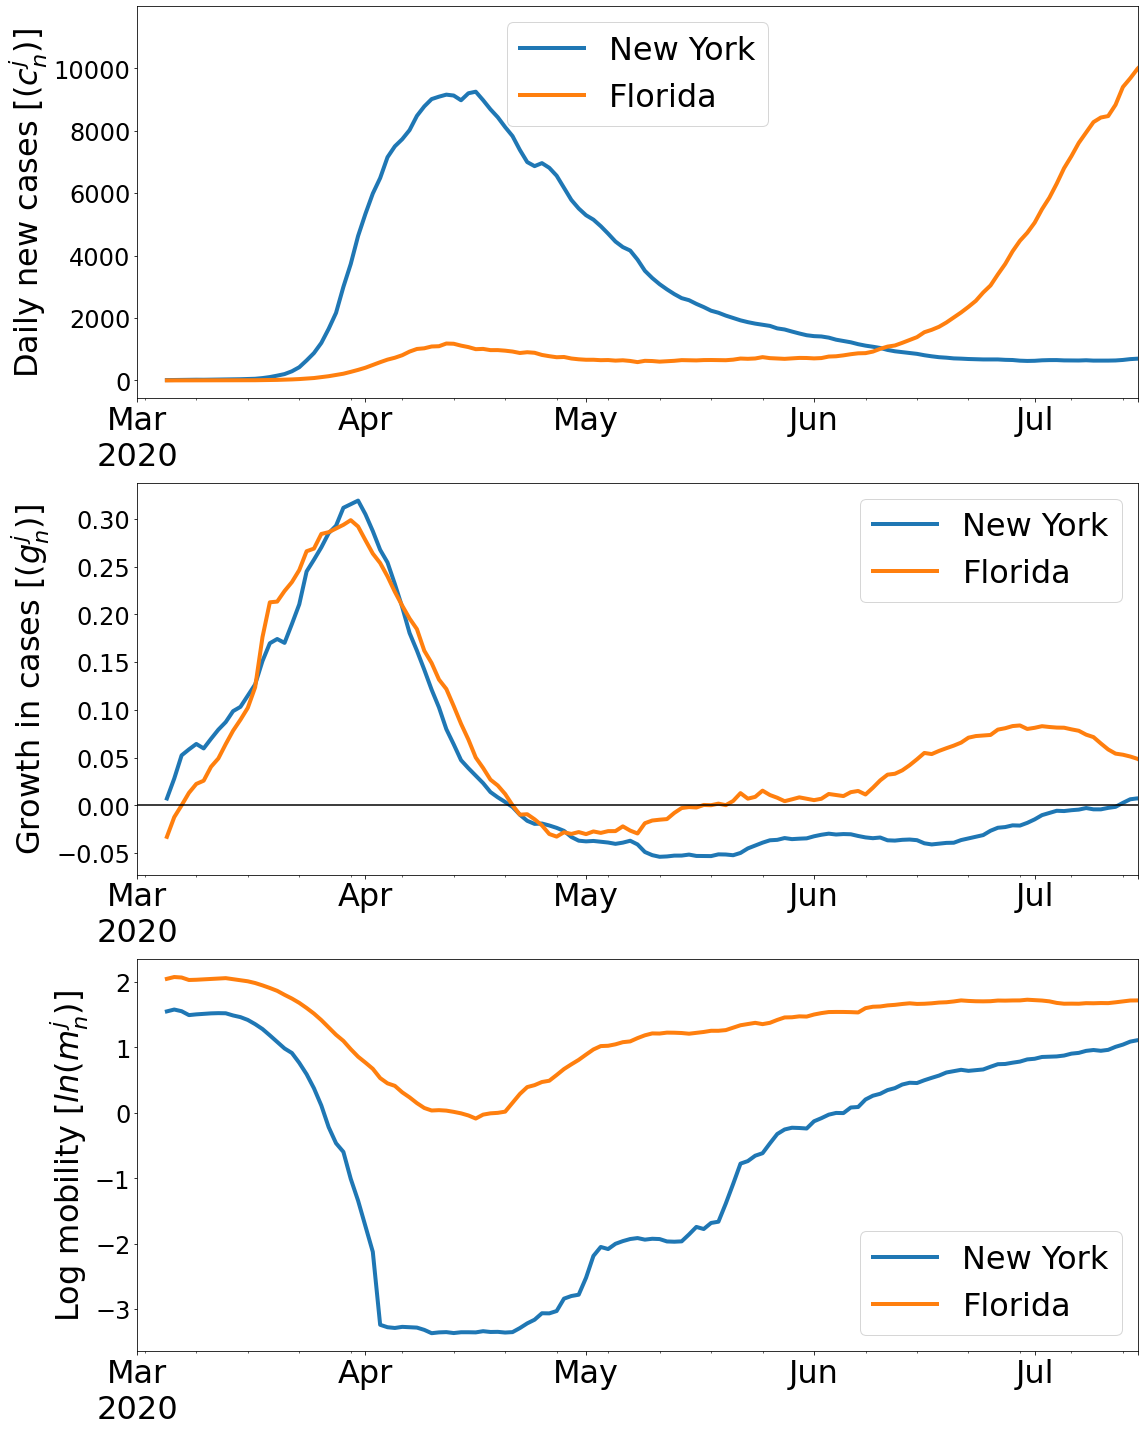

In [12]:
df_states_chosen = df_region[df_region['State'].isin(['Florida', 'New York'])]
df_states_chosen = df_states_chosen.sort_values(by='State', ascending=False)

plt.figure(figsize=(16,20))
ax = plt.subplot(3,1,1)
df_plot = numpy.exp(df_LogCases).copy()
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=32)
plt.ylabel('Daily new cases [$(c^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))
plt.tight_layout()

ax = plt.subplot(3,1,2)
df_plot = df_GrowthCases.copy()
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.axhline(c='k')
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=32)
plt.ylabel('Growth in cases [$(g^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))

ax = plt.subplot(3,1,3)
df_plot = df_LogMobility.copy()
df_plot.index = df_plot.index.to_period(freq='D')
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=12)
plt.ylabel('Log mobility [$ln(m^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))

plt.tight_layout()
plt.savefig(os.path.join(data_subdirectory, 'fig_1_ABC.svg'))
plt.show()

In [13]:
# df1: LogMobility
df1 = df_LogMobility.bfill().ffill()
# Create the multiindex
df1.columns = pandas.MultiIndex.from_product([df1.columns, ['LogMobility']])
df1.columns.names = ['pairs_id', None]

# df2: GrowthCases
# Note: no .bfill().ffill() for GrowthCases. Instead fillna(0) before taking rolling mean
df2 = df_GrowthCases
# Create the multiindex
df2.columns = pandas.MultiIndex.from_product([df2.columns, ['GrowthCases']])
df2.columns.names = ['pairs_id', None]

df_joined = df1.join(df2)
df_joined = df_joined.swaplevel(axis=1)

# Write to disk
df_joined.to_csv(os.path.join(data_subdirectory, 'df_joined_STATE.csv'))

df_joined.tail()

LogMobility                                          \
pairs_id                          121       122       123       124       125   
timestamp                                                                       
2021-01-03 00:00:00+00:00    2.029989  0.584488  1.126158  1.863836  0.068659   
2021-01-04 00:00:00+00:00    2.007725  0.499519  1.059871  1.840550 -0.069733   
2021-01-05 00:00:00+00:00    1.984630  0.498435  1.009287  1.821145 -0.207551   
2021-01-06 00:00:00+00:00    1.967092  0.475568  0.977117  1.803947 -0.321682   
2021-01-07 00:00:00+00:00    1.957133  0.376576  0.909352  1.787811 -0.470804   

                                                                             \
pairs_id                        126       127       128       129       130   
timestamp                                                                     
2021-01-03 00:00:00+00:00  1.170401  1.146336  1.306671 -0.017437  1.670358   
2021-01-04 00:00:00+00:00  1.126621  1.110917  1.264429 -0.121280  1.650402   
2021-01-05 00:00:00+00:00  1.078847  1.063478  1.210580 -0.243437  1.628484   
2021-01-06 00:00:00+00:00  1.055705  1.023144  1.167338 -0.279808  1.610180   
2021-01-07 00:00:00+00:00  1.003516  0.990788  1.128980 -0.242072  1.605358   

                           ... GrowthCases                                \
pairs_id                   ...         162       163       164       165   
timestamp                  ...                                             
2021-01-03 00:00:00+00:00  ...   -0.029374 -0.002758 -0.030678 -0.015736   
2021-01-04 00:00:00+00:00  ...   -0.030184 -0.002890 -0.033522 -0.016329   
2021-01-05 00:00:00+00:00  ...   -0.030800 -0.004837 -0.032105 -0.016755   
2021-01-06 00:00:00+00:00  ...   -0.027601 -0.005121 -0.031958 -0.016620   
2021-01-07 00:00:00+00:00  ...   -0.026160 -0.007691 -0.031290 -0.014469   

                                                                             \
pairs_id                        166       167       168       169       170   
timestamp                                                                     
2021-01-03 00:00:00+00:00  0.000328  0.003671 -0.003111 -0.005826 -0.039454   
2021-01-04 00:00:00+00:00 -0.002014  0.003869 -0.000472 -0.006255 -0.041791   
2021-01-05 00:00:00+00:00 -0.002181  0.004167  0.001302 -0.007907 -0.040423   
2021-01-06 00:00:00+00:00 -0.002063  0.005367  0.003222 -0.007208 -0.039469   
2021-01-07 00:00:00+00:00 -0.000506  0.005975  0.005964 -0.007287 -0.037459   

                                     
pairs_id                        171  
timestamp                            
2021-01-03 00:00:00+00:00 -0.053509  
2021-01-04 00:00:00+00:00 -0.050234  
2021-01-05 00:00:00+00:00 -0.048257  
2021-01-06 00:00:00+00:00 -0.047078  
2021-01-07 00:00:00+00:00 -0.047043  

[5 rows x 102 columns]

/home/ipython/software/python/python37/virtualenvs/pairs-python3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ipython/software/python/python37/virtualenvs/pairs-python3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


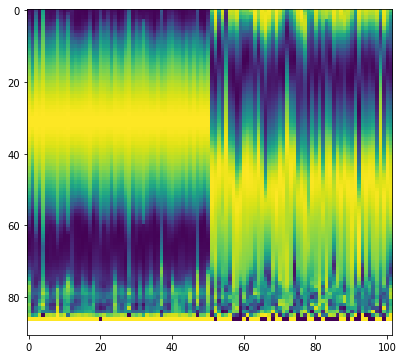

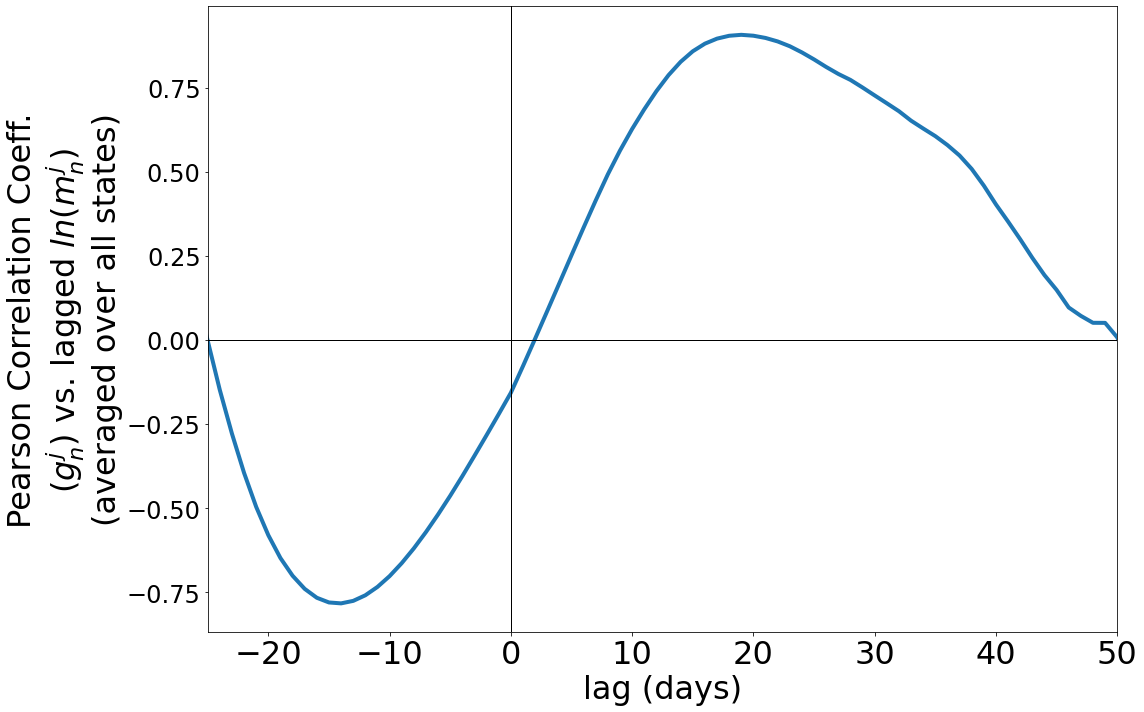

19 0.9065984878215763


In [14]:
# Correlation with LogMobility
lag_days = numpy.arange(91) - 31
dt_cutoff_start = datetime(2020, 1, 1, tzinfo=pytz.utc)
dt_cutoff_end = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_lagged_correlation = pandas.DataFrame()
for pairs_id in df_region['pairs_id'].values:
    df = df_joined[['LogMobility', 'GrowthCases']].swaplevel(axis=1)[pairs_id]
    df = df[df.index>=dt_cutoff_start]
    df = df[df.index<=dt_cutoff_end]

    lagged_correlation = pandas.DataFrame.from_dict(
        {x: [df['LogMobility'].corr(df[x].shift(-t)) for t in lag_days] for x in df.columns})
    lagged_correlation['pairs_id'] = pairs_id
    lagged_correlation['lag_days'] = lag_days
    df_lagged_correlation = pandas.concat([df_lagged_correlation, lagged_correlation])
    
df_lagged_correlation = df_lagged_correlation.set_index(['lag_days', 'pairs_id']).unstack()

plt.figure(figsize=(20,6))
plt.imshow(df_lagged_correlation)
plt.show()

df_lagged_correlation.head()

from matplotlib.offsetbox import AnchoredText
plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.plot(df_lagged_correlation['GrowthCases'].mean(axis=1), lw=4)
plt.xlabel('lag (days)', size=32)
plt.ylabel('Pearson Correlation Coeff.\n$(g^j_n)$ vs. lagged $ln(m^j_n)$\n(averaged over all states)', size=32)
plt.axvline(color='k', lw=1)
plt.axhline(color='k', lw=1)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.xlim(xmin=-25, xmax=50)
plt.tight_layout()
plt.savefig(os.path.join(data_subdirectory, 'fig_1_D.svg'))
plt.show()

cases_lag_measured = df_lagged_correlation['GrowthCases'].mean(axis=1).idxmax()
print(cases_lag_measured, df_lagged_correlation.loc[cases_lag_measured, 'GrowthCases'].mean())

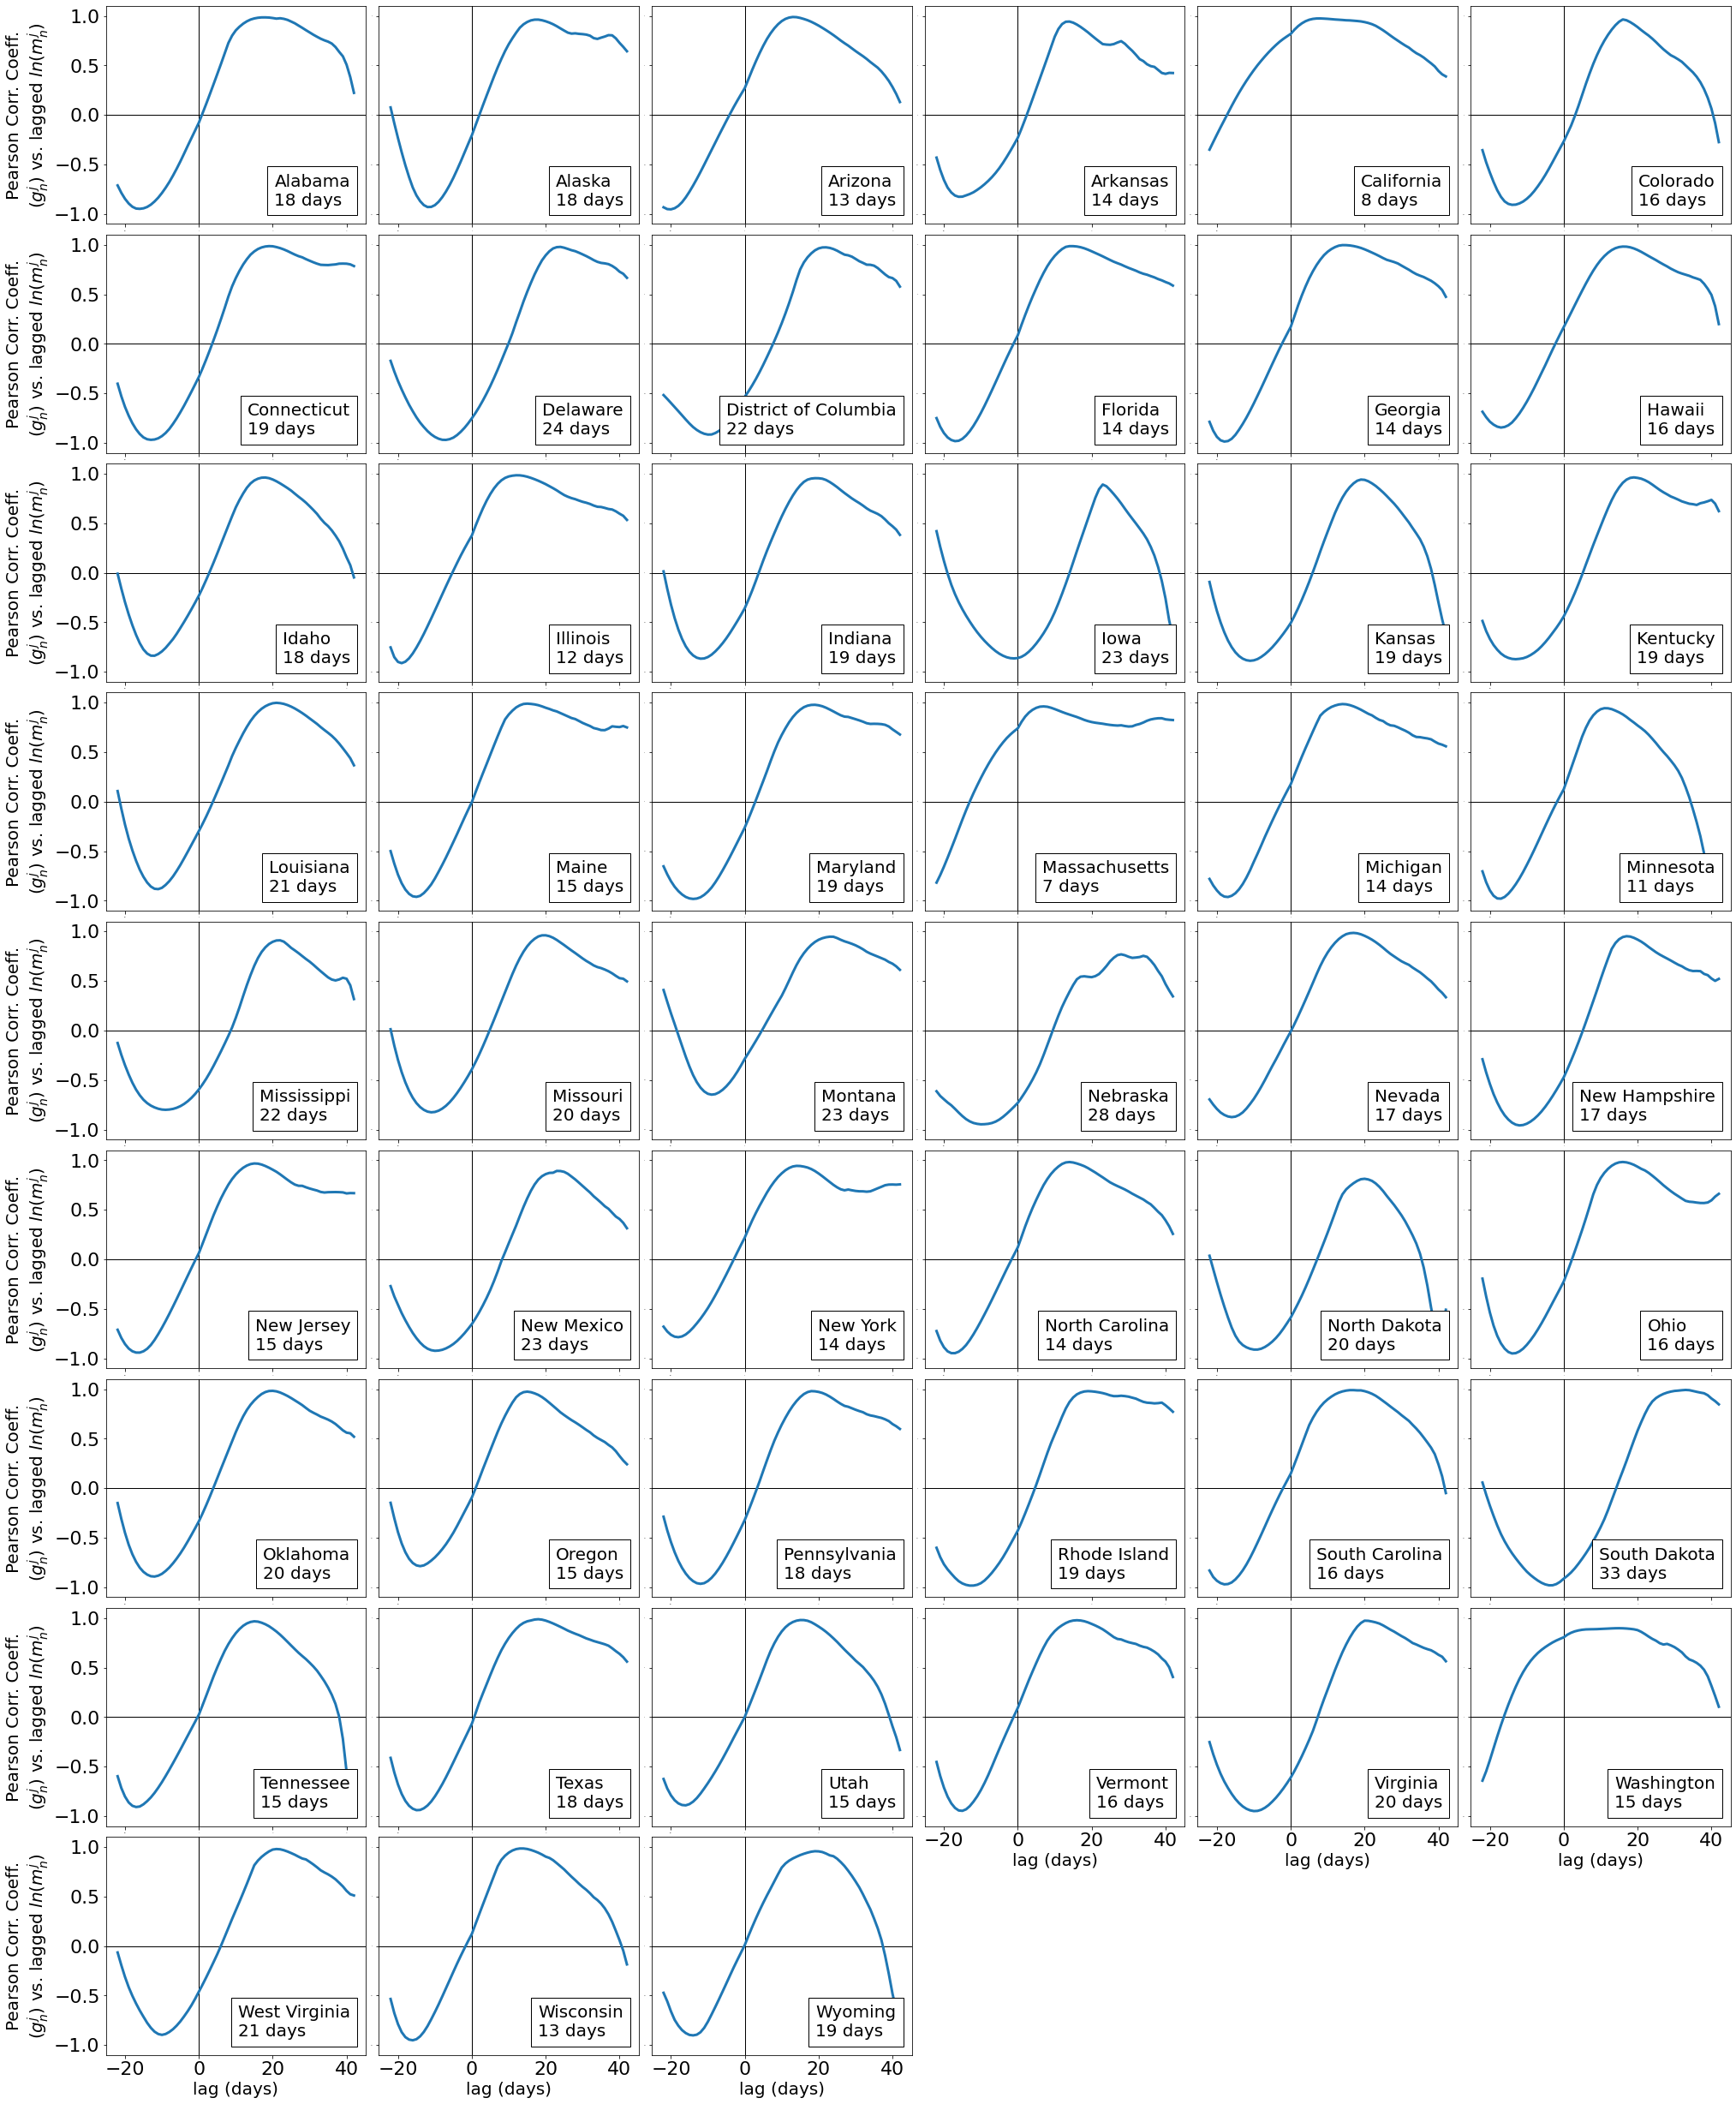

In [15]:
# Individual State Correlations
df_state_correlations = pandas.DataFrame()

fig = plt.figure(figsize=(34, 44)) # letter size 8.5 * 11
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, pairs_id in enumerate(df_region.sort_values(by='State')['pairs_id'].values):

    df_single = df_lagged_correlation['GrowthCases'][pairs_id]
    df_single = df_single.loc[-22:42]

    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]
    row['argmax'] = df_single.idxmax()
    row['R'] = numpy.round(df_single.max(), 2)
    
    if len(df_single)>0:
        ax = plt.subplot(9, 6,i+1)
        plt.axhline(color='k', lw=1)
        plt.axvline(color='k', lw=1)
        
        plt.plot(df_single, lw=3)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        ax.locator_params(tight=True, nbins=5)
            
        #plt.xlim(xmin=-2.5, xmax=1.5)
        plt.ylim(ymin=-1.1, ymax=1.1)

        anchored_text = AnchoredText(title_string + '\n' + str(row['argmax']) + ' days', loc=4, prop=dict(size=20))
        ax.add_artist(anchored_text)

        df_state_correlations = df_state_correlations.append(pandas.DataFrame(row, index=[0]))

        if (i>44):
            plt.xlabel('lag (days)', size=20)
            plt.xticks(fontsize=22)
        else:
            plt.xticks(fontsize=0)
            
        if (i%6==0):
            plt.ylabel('Pearson Corr. Coeff.\n$(g^j_n)$ vs. lagged $ln(m^j_n)$', size=20)
            plt.yticks(fontsize=22)
        else:
            plt.yticks(fontsize=0)

#plt.tight_layout()
plt.savefig(os.path.join(data_subdirectory, 'state_correlations_RW14.svg'))
plt.show()

In [16]:
df_state_correlations[['argmax', 'R']].describe()

argmax          R
count  51.000000  51.000000
mean   17.549020   0.959412
std     4.531286   0.043100
min     7.000000   0.770000
25%    15.000000   0.955000
50%    18.000000   0.970000
75%    20.000000   0.980000
max    33.000000   1.000000

In [17]:
lag_cases = cases_lag_measured
print('cases_lag_measured', cases_lag_measured)
# Shifting only the growth
df_lagged_growth_cases = df_joined[['GrowthCases']].shift(periods=-lag_cases)
df_lagged = pandas.merge(df_joined[['LogMobility']],
                          df_joined[['GrowthCases']].shift(periods=-lag_cases),
                          left_index=True,
                          right_index=True)

df_lagged = df_lagged.swaplevel(axis=1)
df_lagged.tail()

cases_lag_measured 19


pairs_id                          121         122         123         124  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2021-01-03 00:00:00+00:00    2.029989    0.584488    1.126158    1.863836   
2021-01-04 00:00:00+00:00    2.007725    0.499519    1.059871    1.840550   
2021-01-05 00:00:00+00:00    1.984630    0.498435    1.009287    1.821145   
2021-01-06 00:00:00+00:00    1.967092    0.475568    0.977117    1.803947   
2021-01-07 00:00:00+00:00    1.957133    0.376576    0.909352    1.787811   

pairs_id                          125         126         127         128  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2021-01-03 00:00:00+00:00    0.068659    1.170401    1.146336    1.306671   
2021-01-04 00:00:00+00:00   -0.069733    1.126621    1.110917    1.264429   
2021-01-05 00:00:00+00:00   -0.207551    1.078847    1.063478    1.210580   
2021-01-06 00:00:00+00:00   -0.321682    1.055705    1.023144    1.167338   
2021-01-07 00:00:00+00:00   -0.470804    1.003516    0.990788    1.128980   

pairs_id                          129         130  ...         162  \
                          LogMobility LogMobility  ... GrowthCases   
timestamp                                          ...               
2021-01-03 00:00:00+00:00   -0.017437    1.670358  ...         NaN   
2021-01-04 00:00:00+00:00   -0.121280    1.650402  ...         NaN   
2021-01-05 00:00:00+00:00   -0.243437    1.628484  ...         NaN   
2021-01-06 00:00:00+00:00   -0.279808    1.610180  ...         NaN   
2021-01-07 00:00:00+00:00   -0.242072    1.605358  ...         NaN   

pairs_id                          163         164         165         166  \
                          GrowthCases GrowthCases GrowthCases GrowthCases   
timestamp                                                                   
2021-01-03 00:00:00+00:00         NaN         NaN         NaN         NaN   
2021-01-04 00:00:00+00:00         NaN         NaN         NaN         NaN   
2021-01-05 00:00:00+00:00         NaN         NaN         NaN         NaN   
2021-01-06 00:00:00+00:00         NaN         NaN         NaN         NaN   
2021-01-07 00:00:00+00:00         NaN         NaN         NaN         NaN   

pairs_id                          167         168         169         170  \
                          GrowthCases GrowthCases GrowthCases GrowthCases   
timestamp                                                                   
2021-01-03 00:00:00+00:00         NaN         NaN         NaN         NaN   
2021-01-04 00:00:00+00:00         NaN         NaN         NaN         NaN   
2021-01-05 00:00:00+00:00         NaN         NaN         NaN         NaN   
2021-01-06 00:00:00+00:00         NaN         NaN         NaN         NaN   
2021-01-07 00:00:00+00:00         NaN         NaN         NaN         NaN   

pairs_id                          171  
                          GrowthCases  
timestamp                              
2021-01-03 00:00:00+00:00         NaN  
2021-01-04 00:00:00+00:00         NaN  
2021-01-05 00:00:00+00:00         NaN  
2021-01-06 00:00:00+00:00         NaN  
2021-01-07 00:00:00+00:00         NaN  

[5 rows x 102 columns]

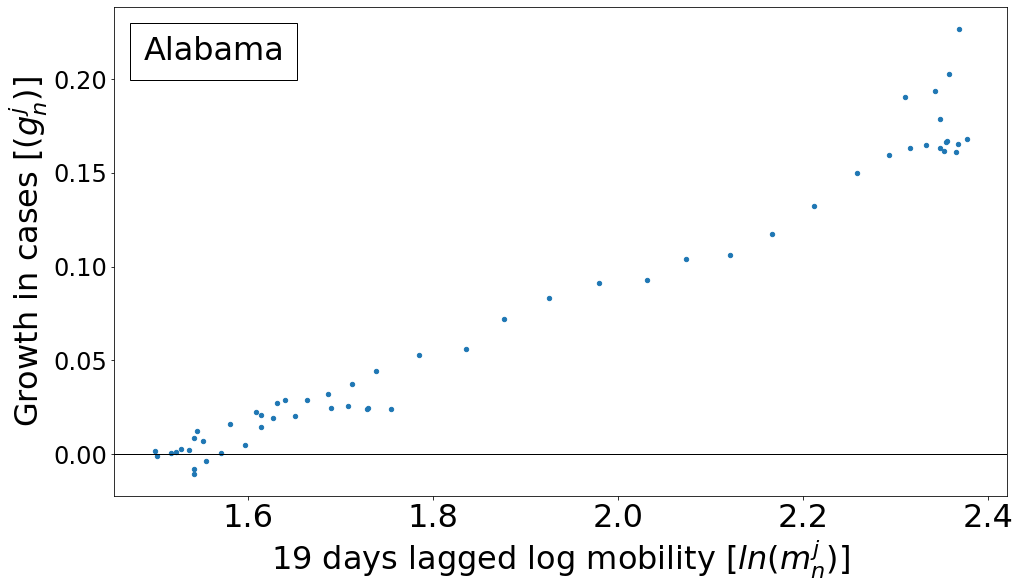

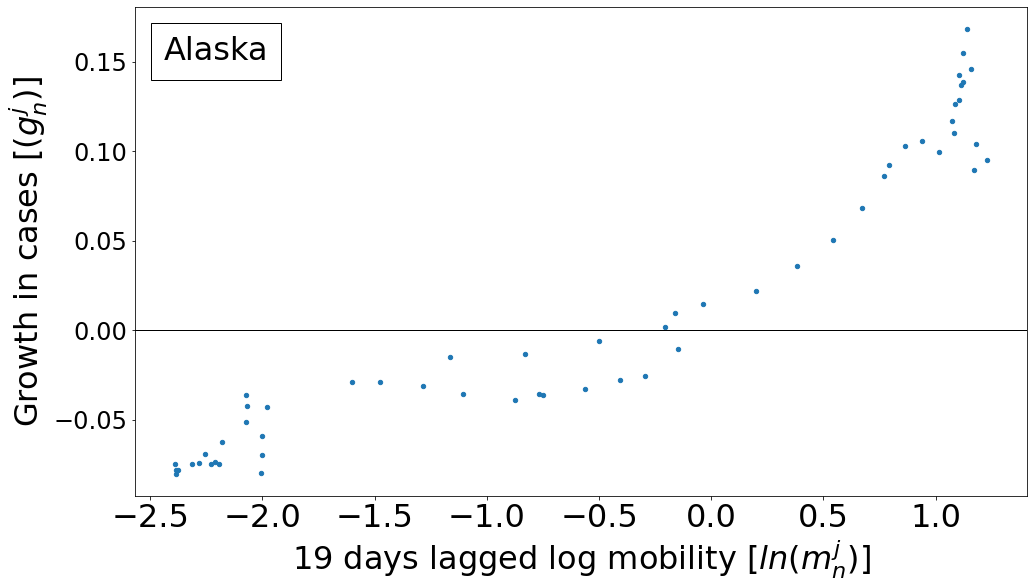

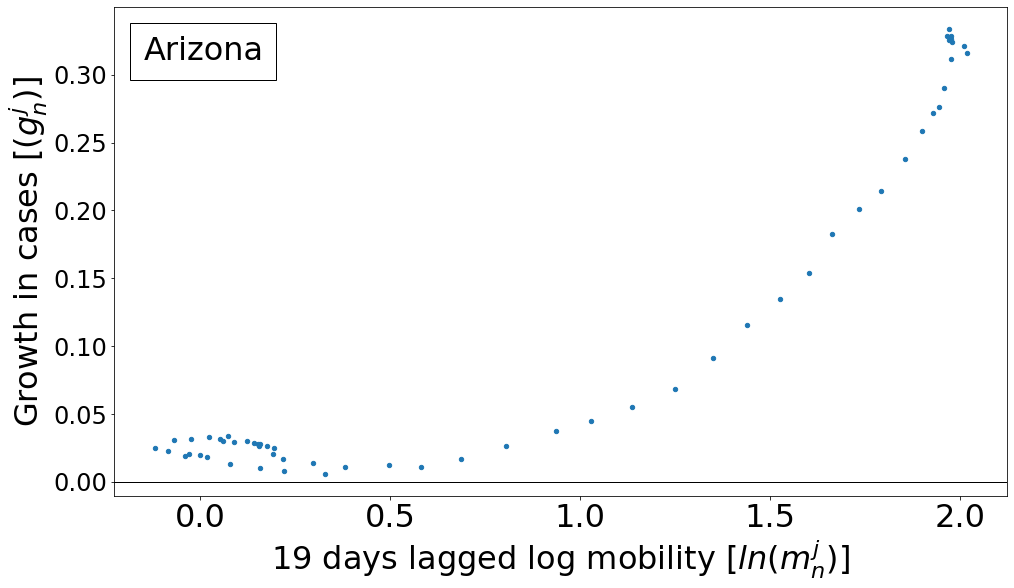

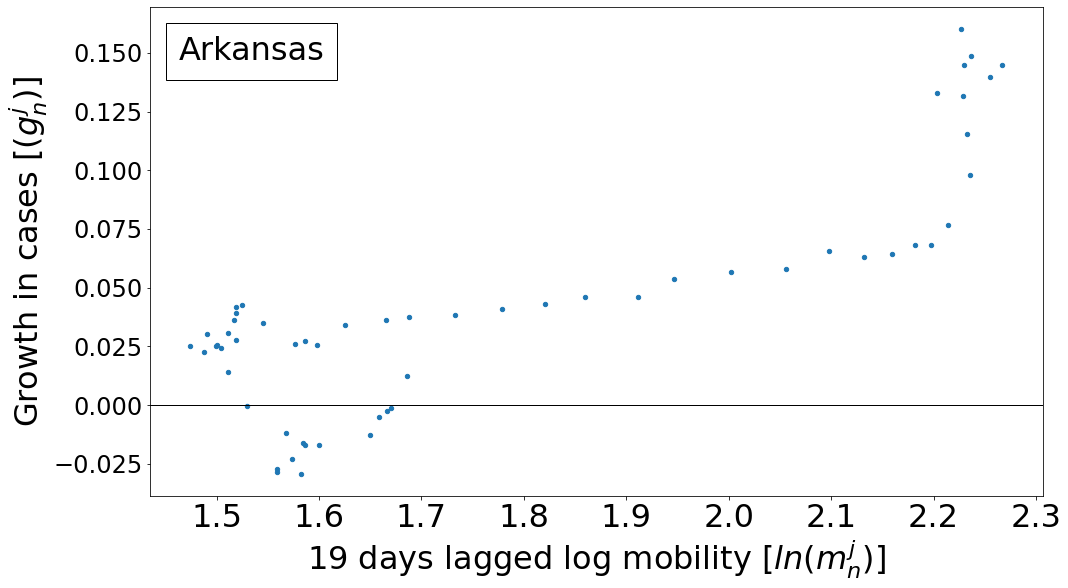

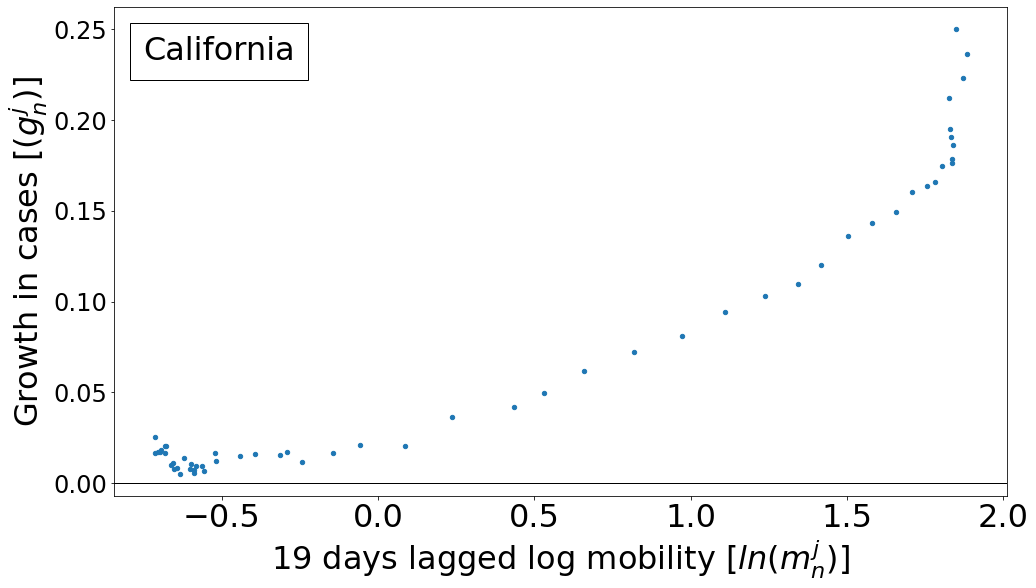

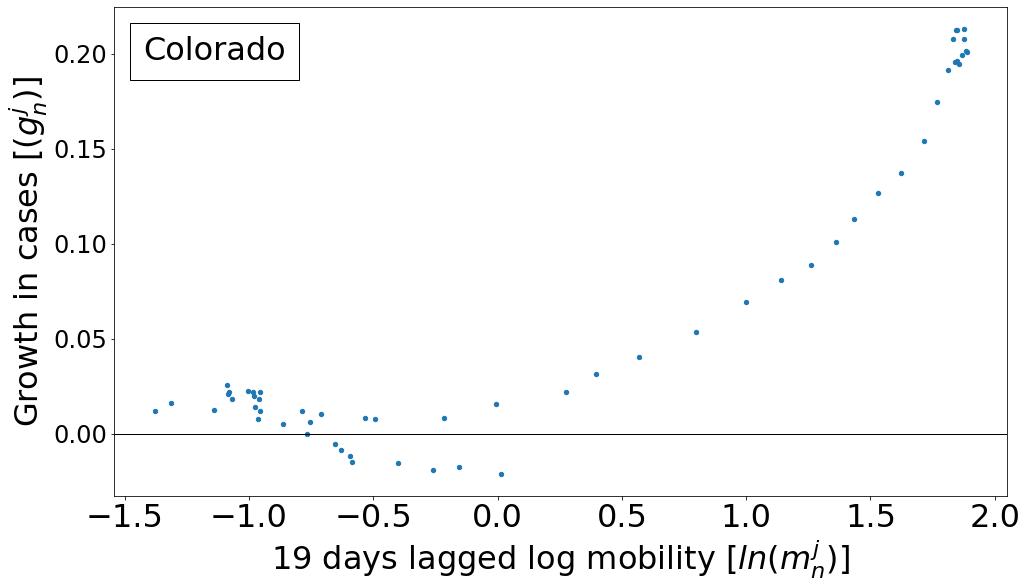

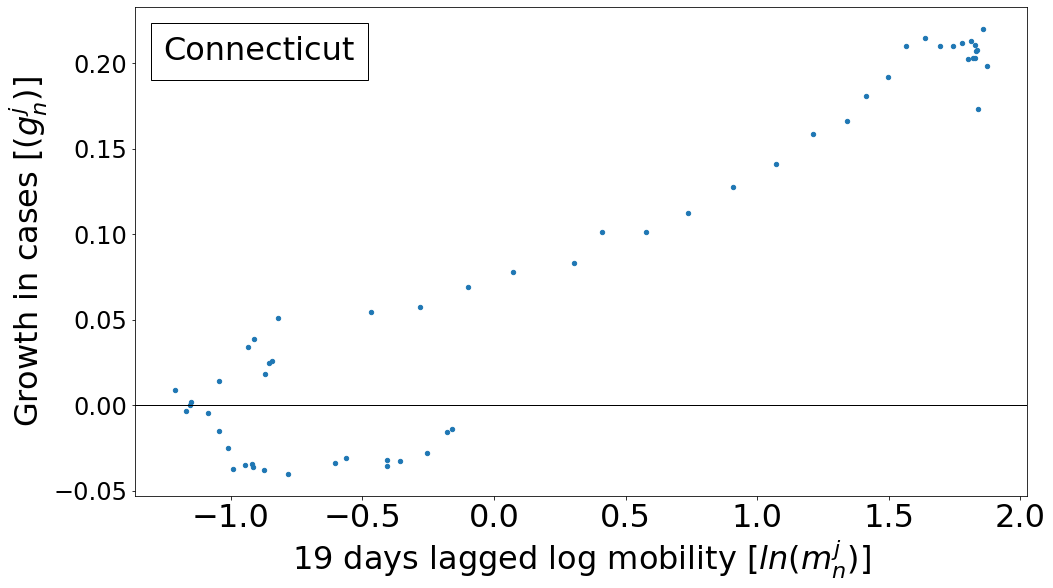

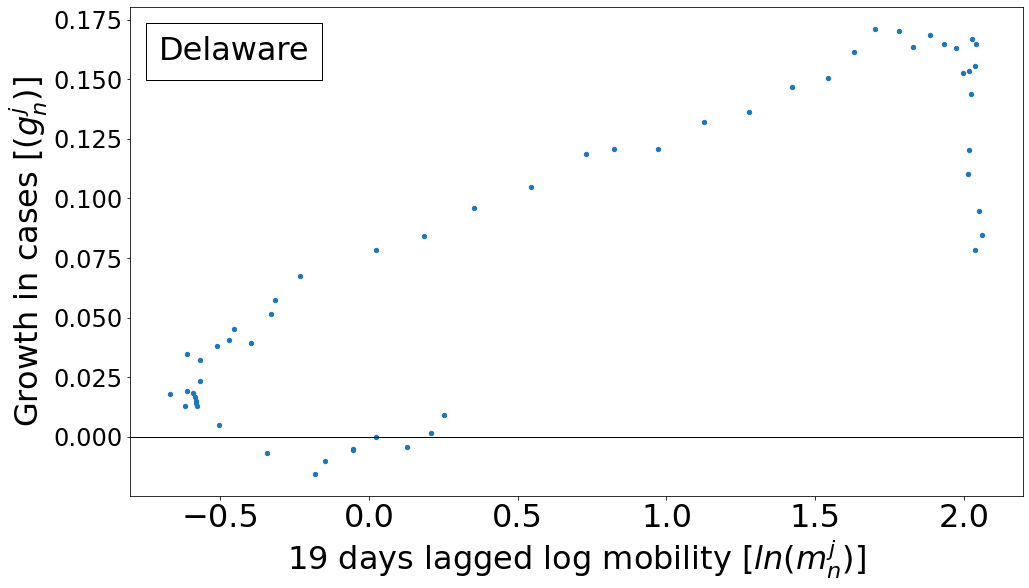

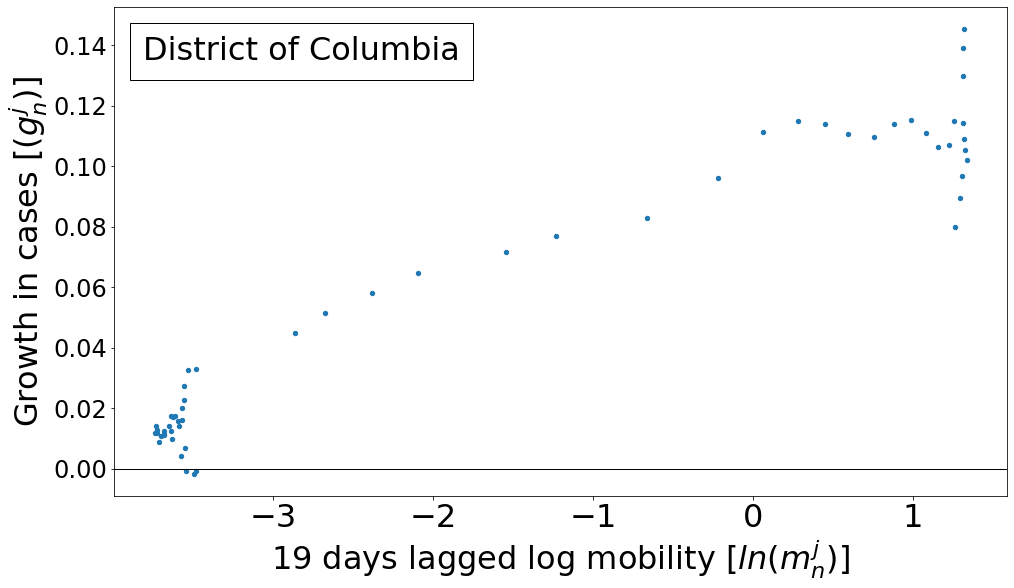

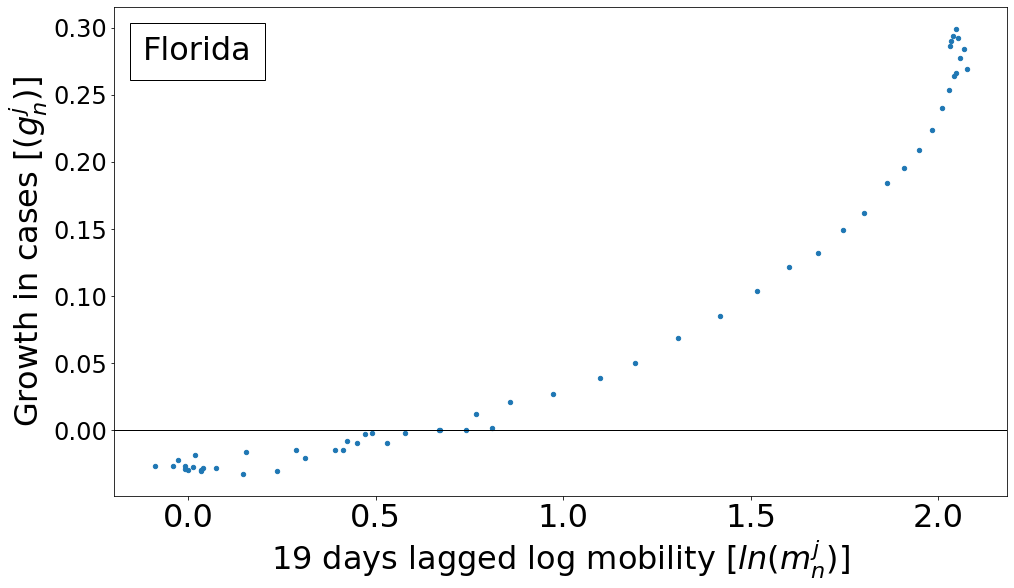

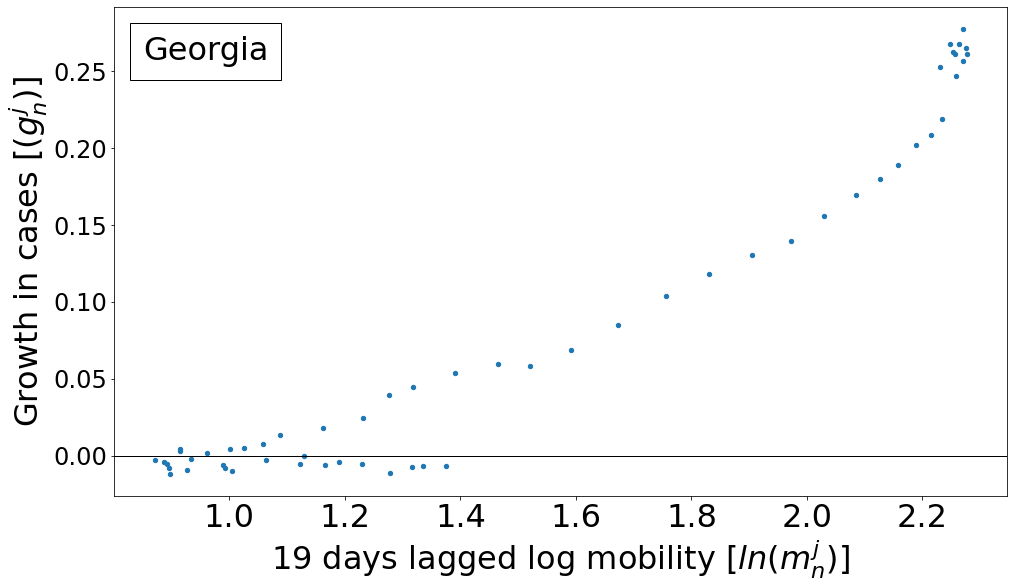

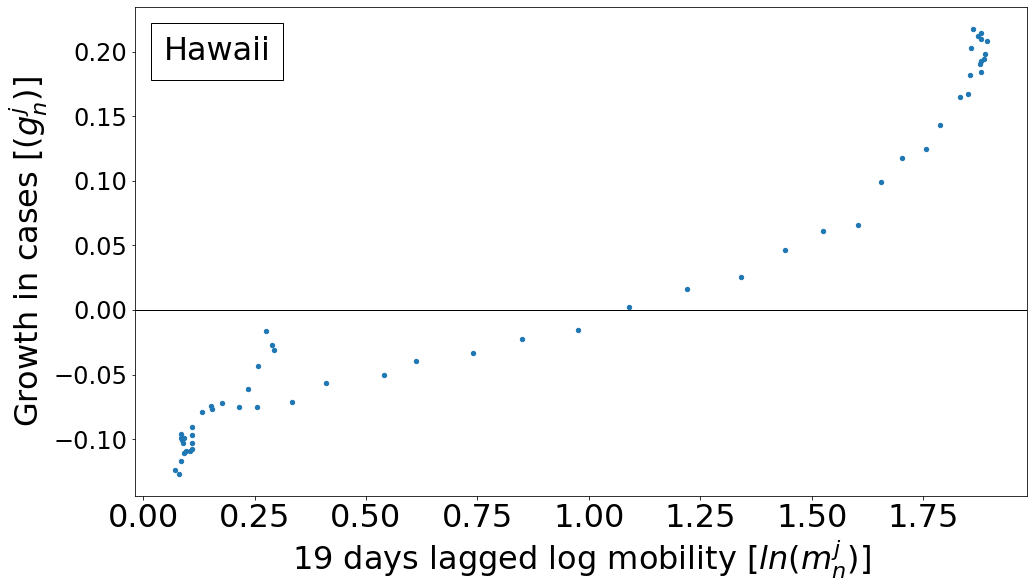

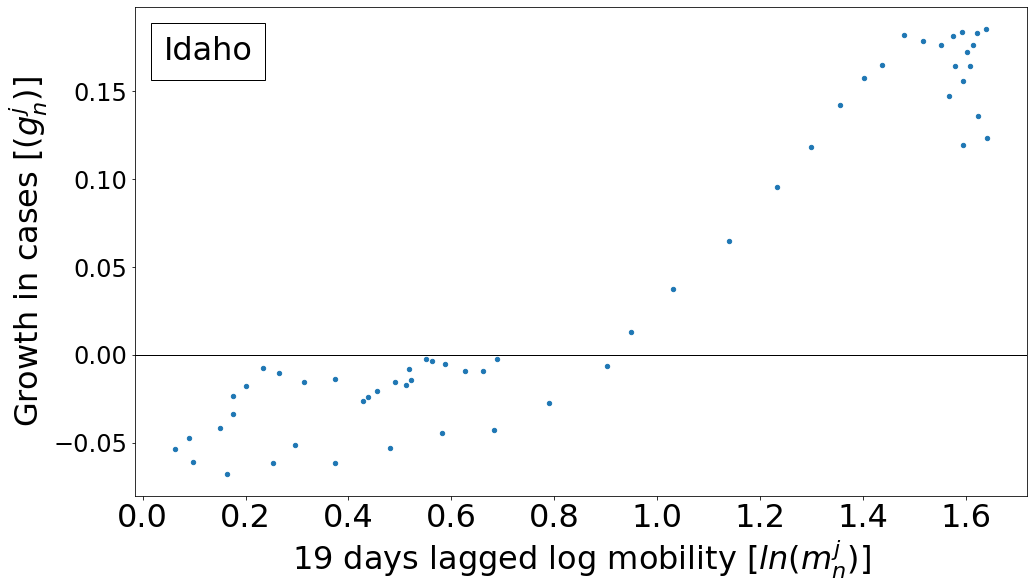

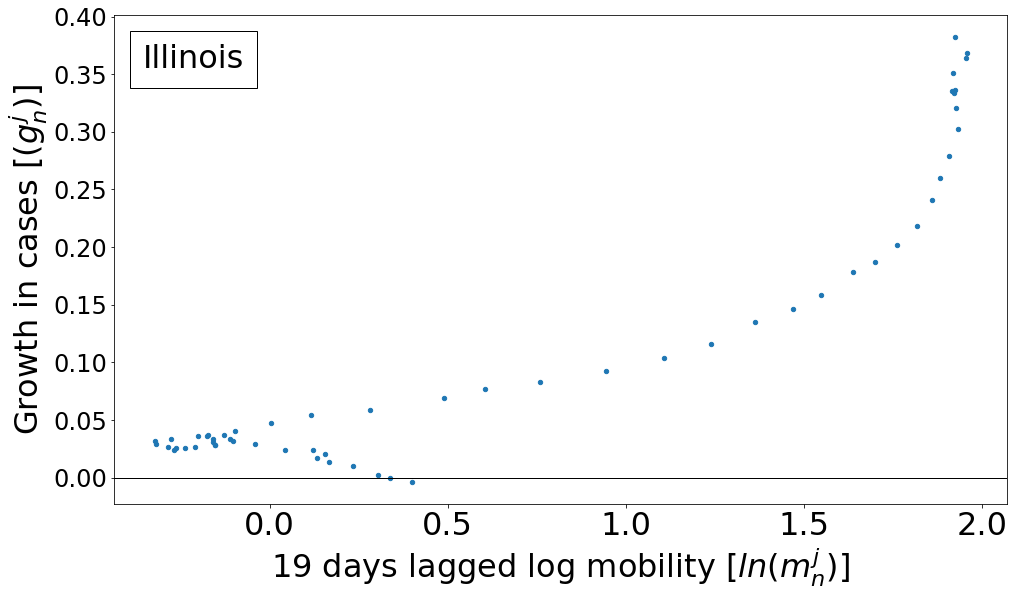

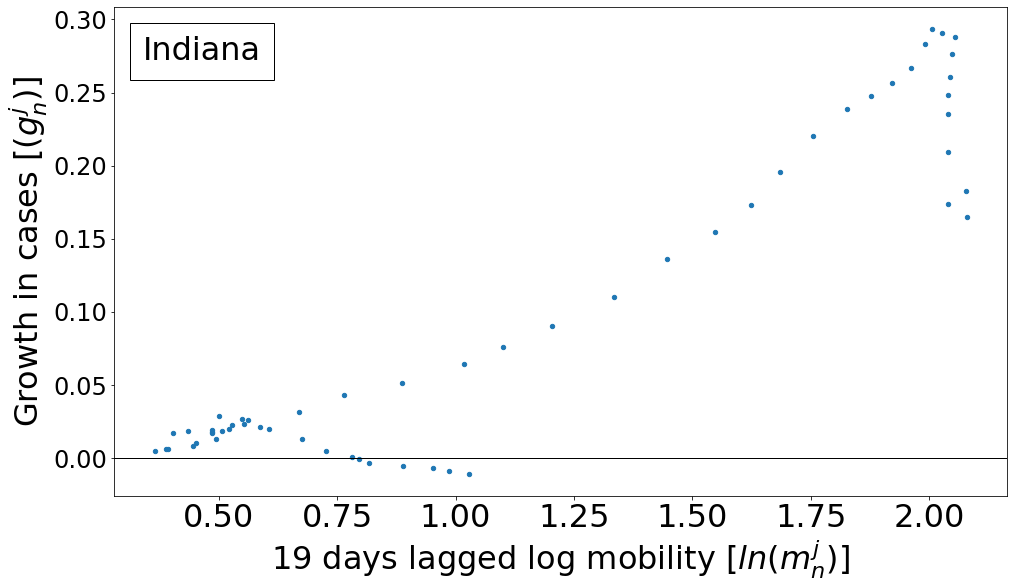

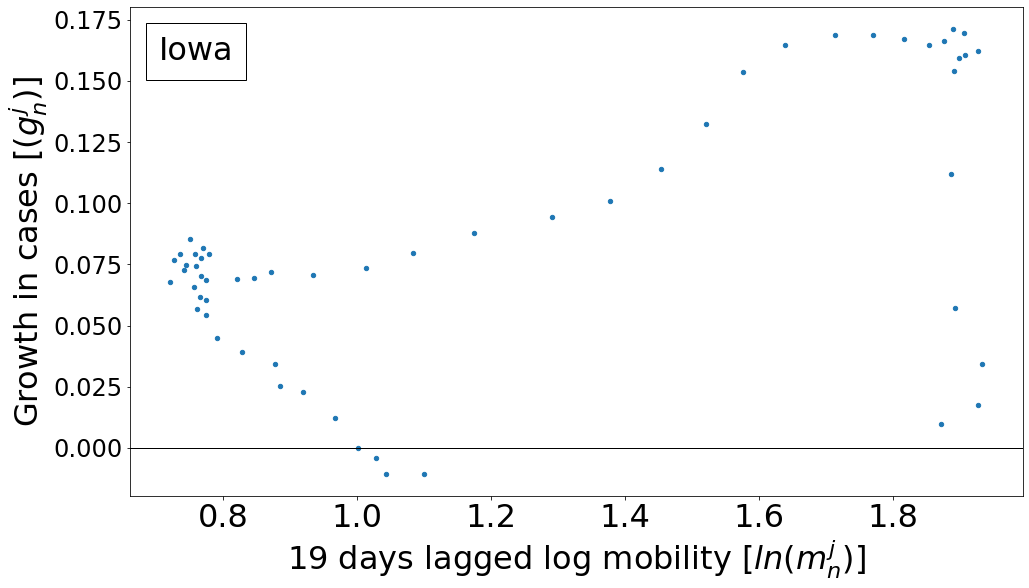

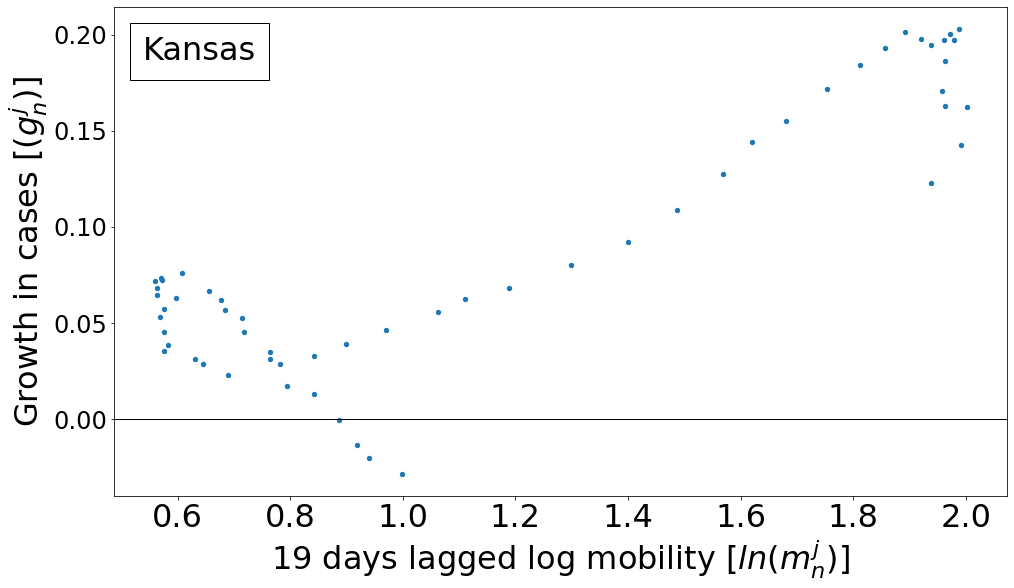

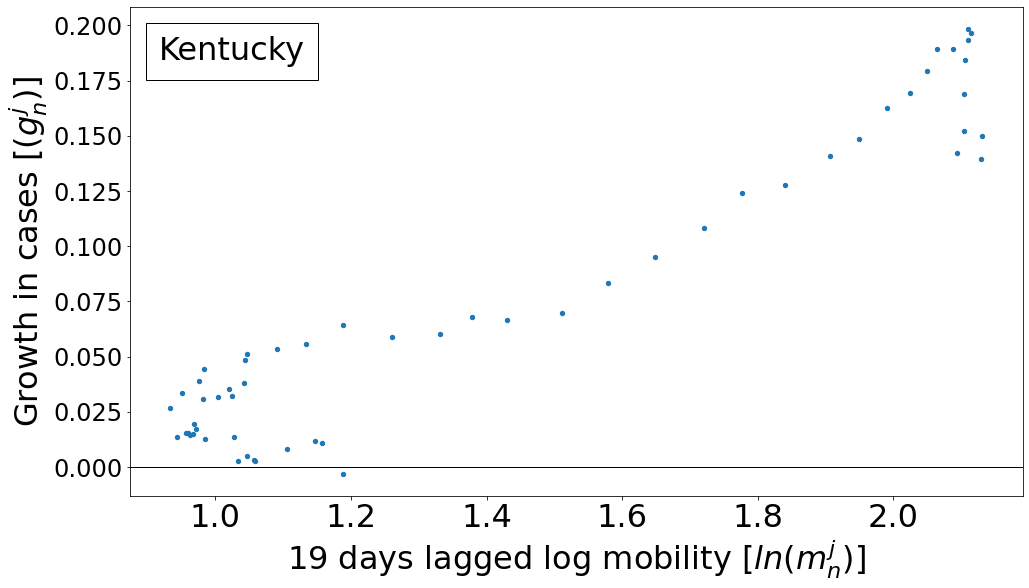

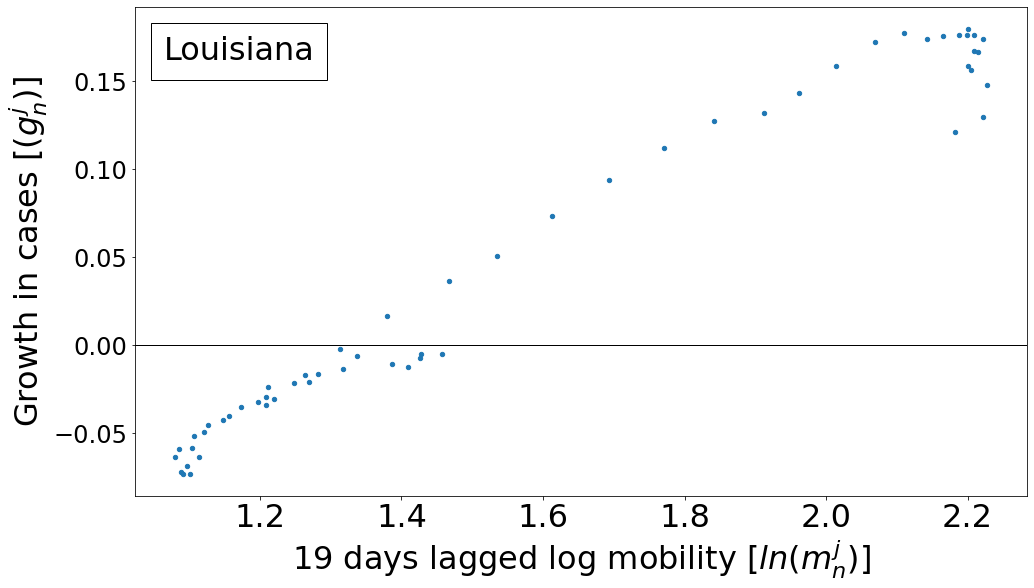

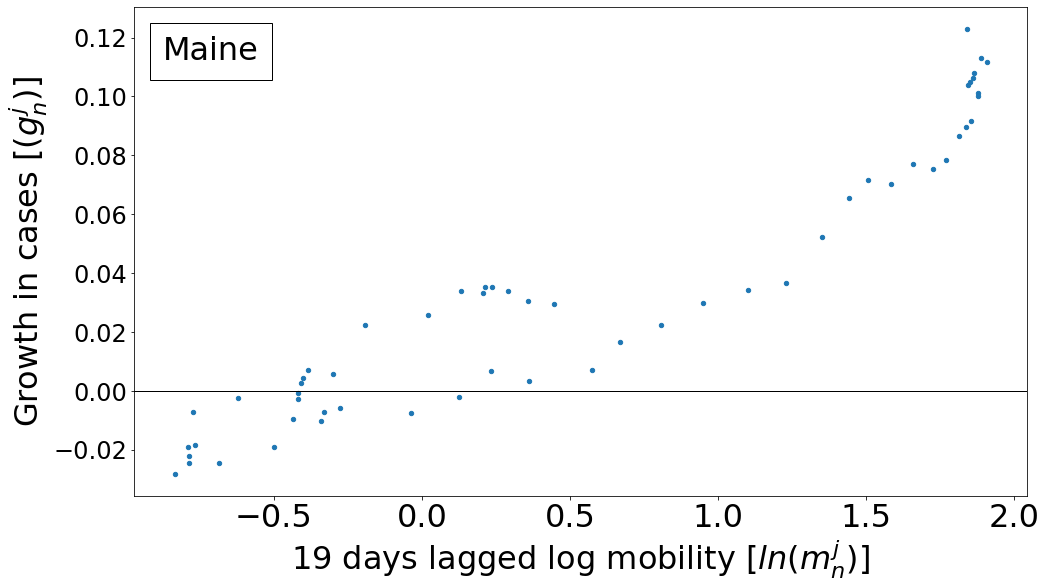

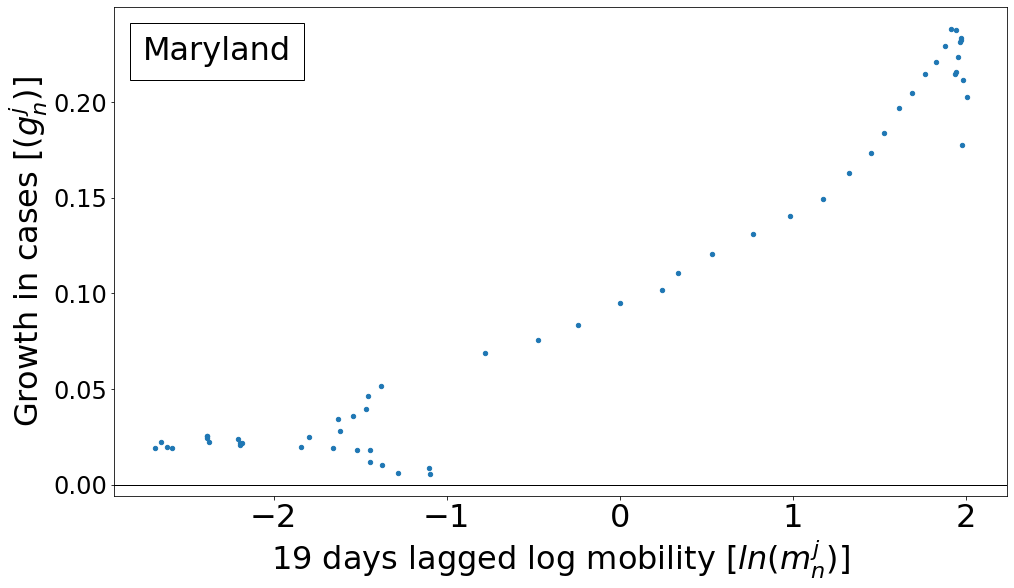

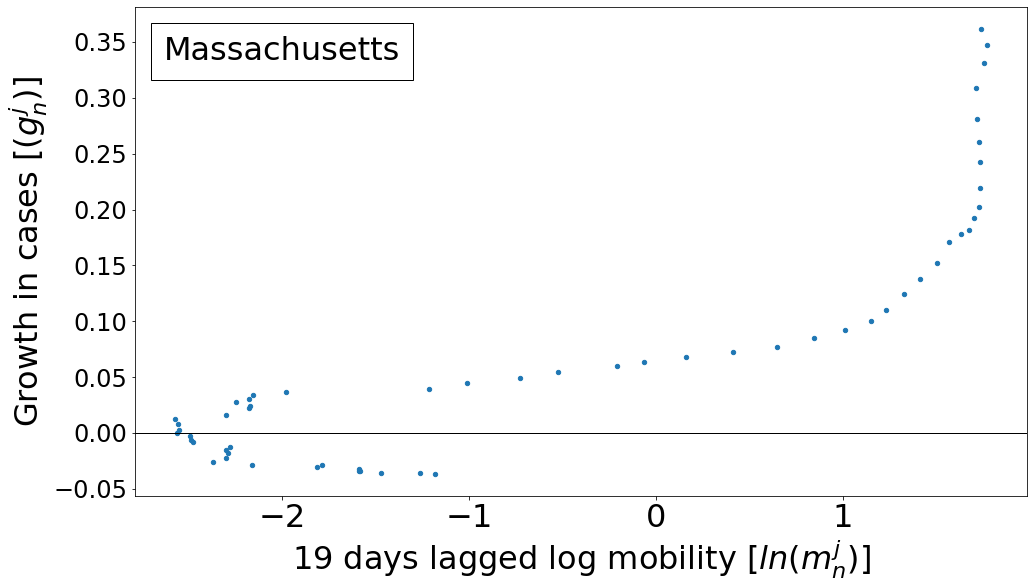

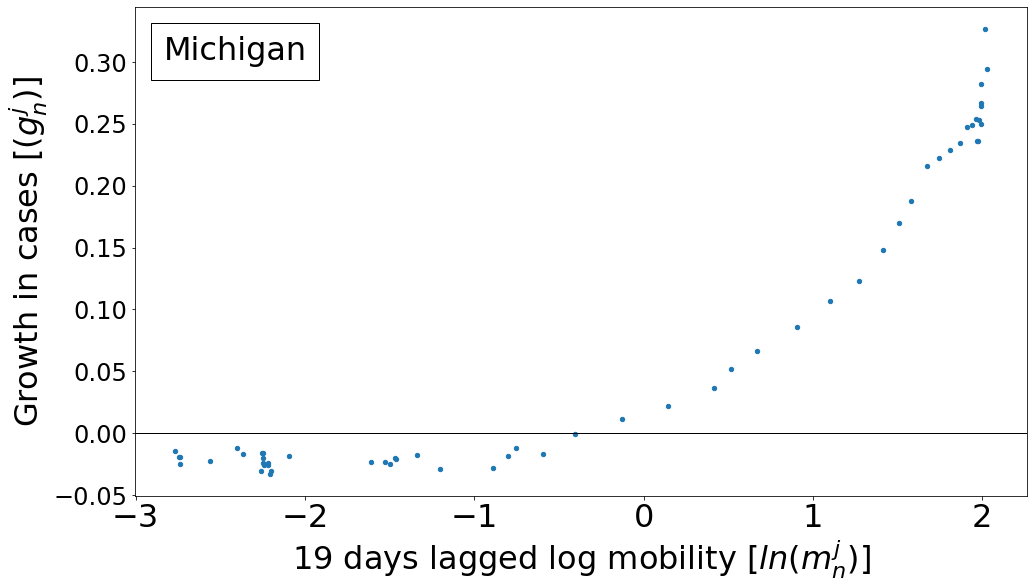

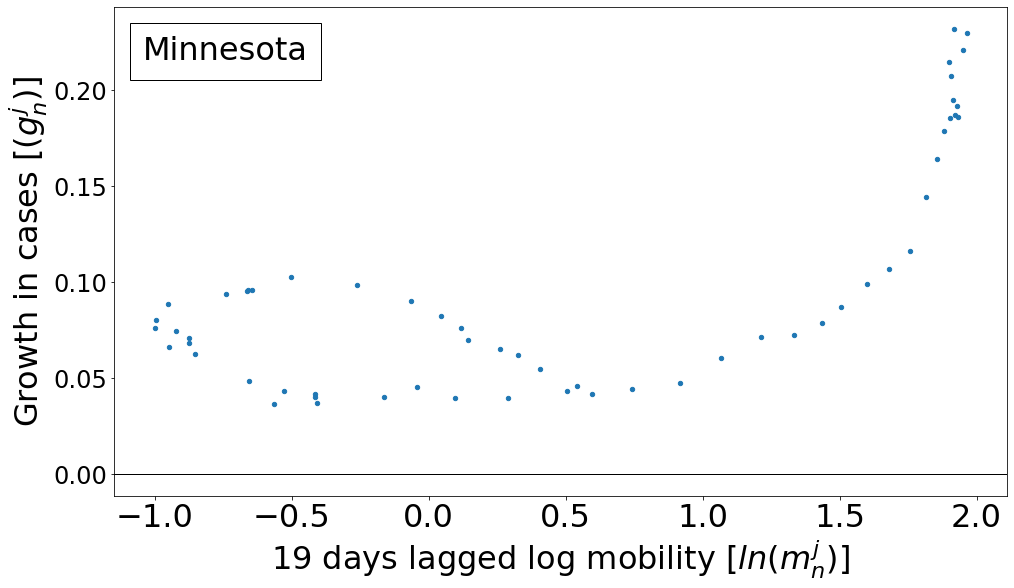

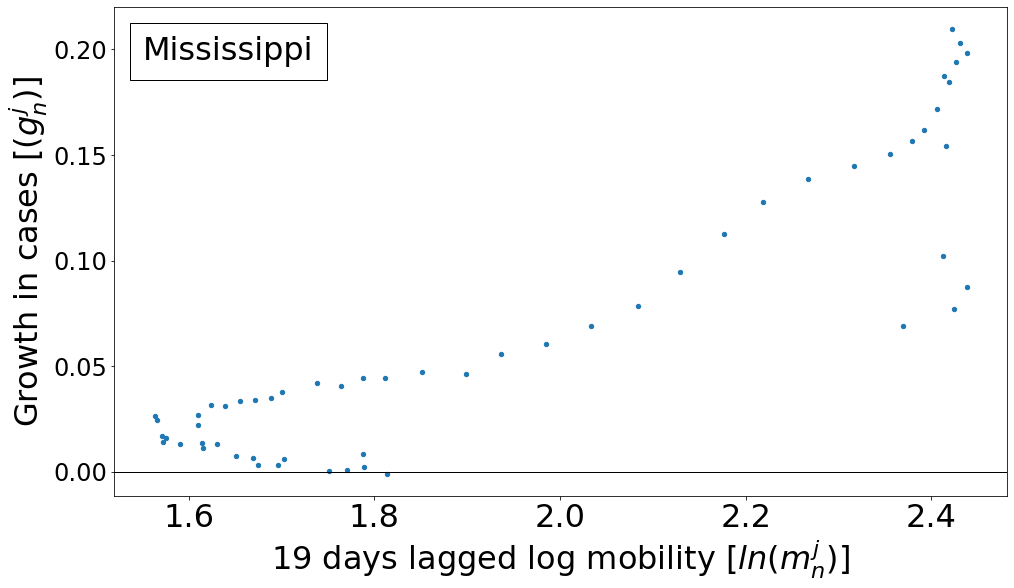

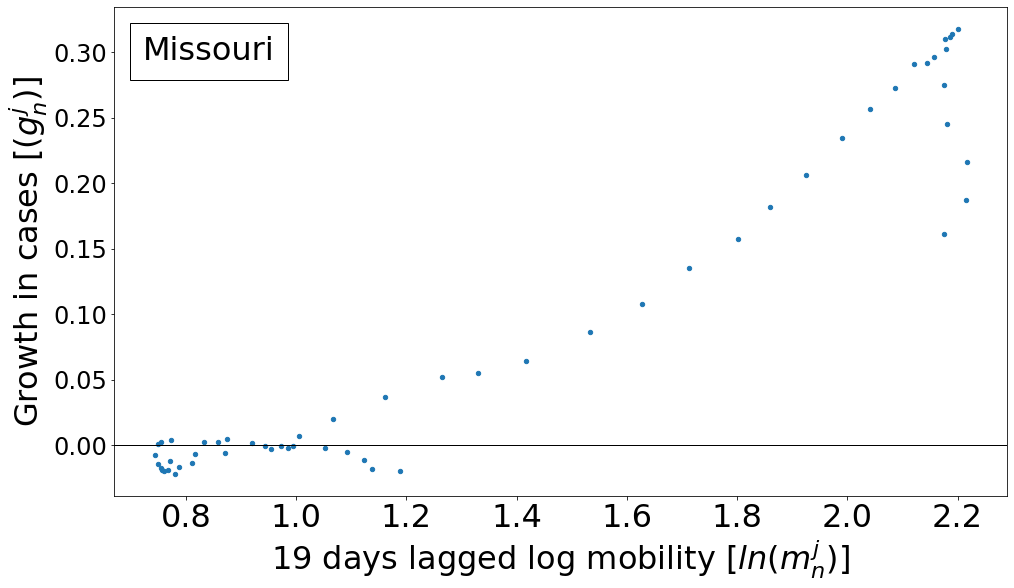

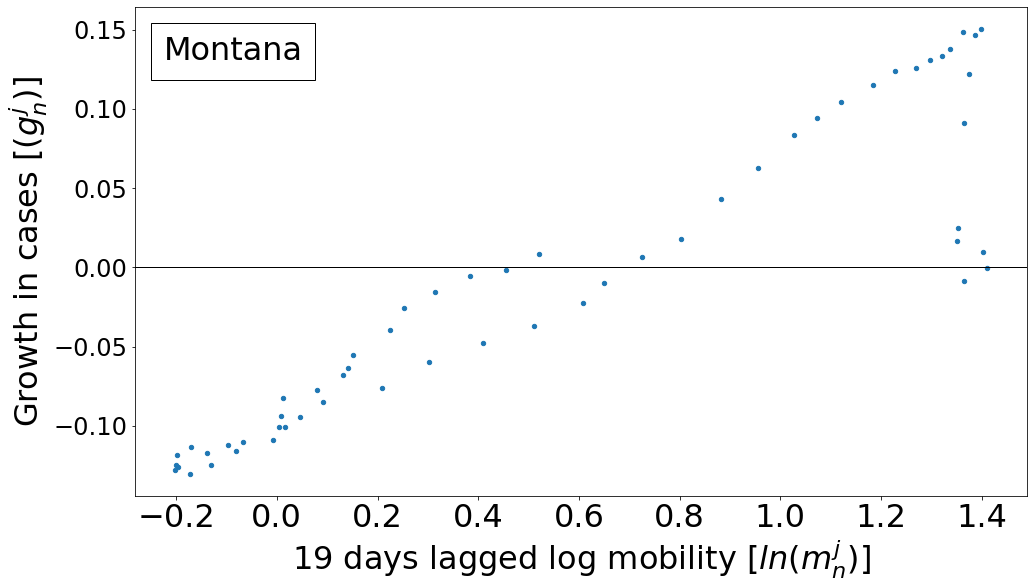

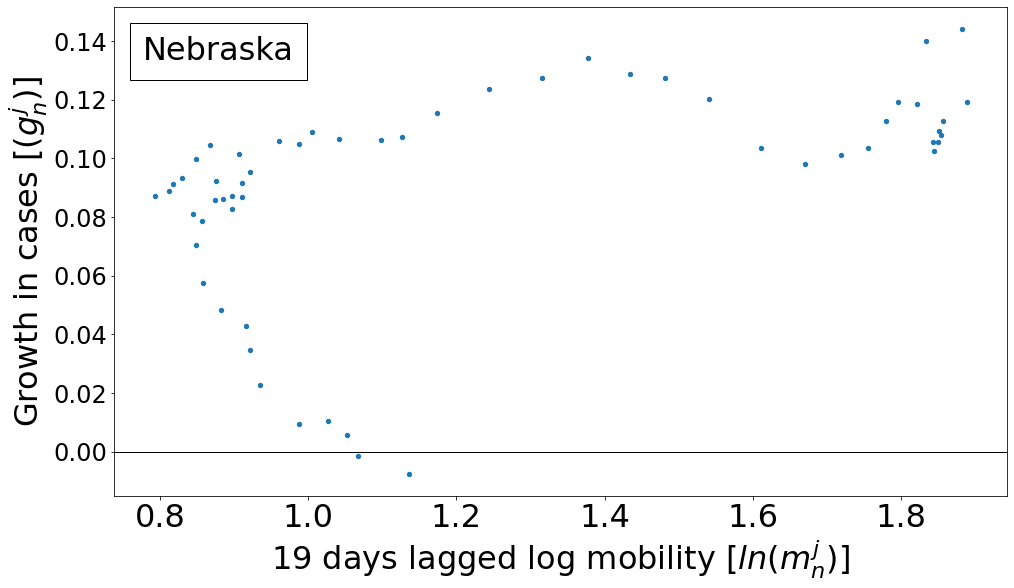

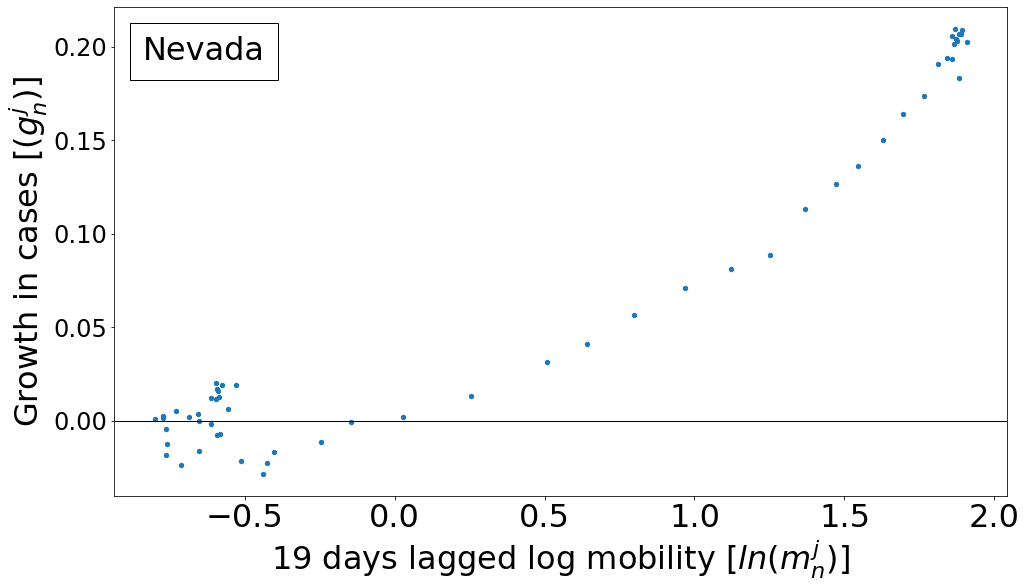

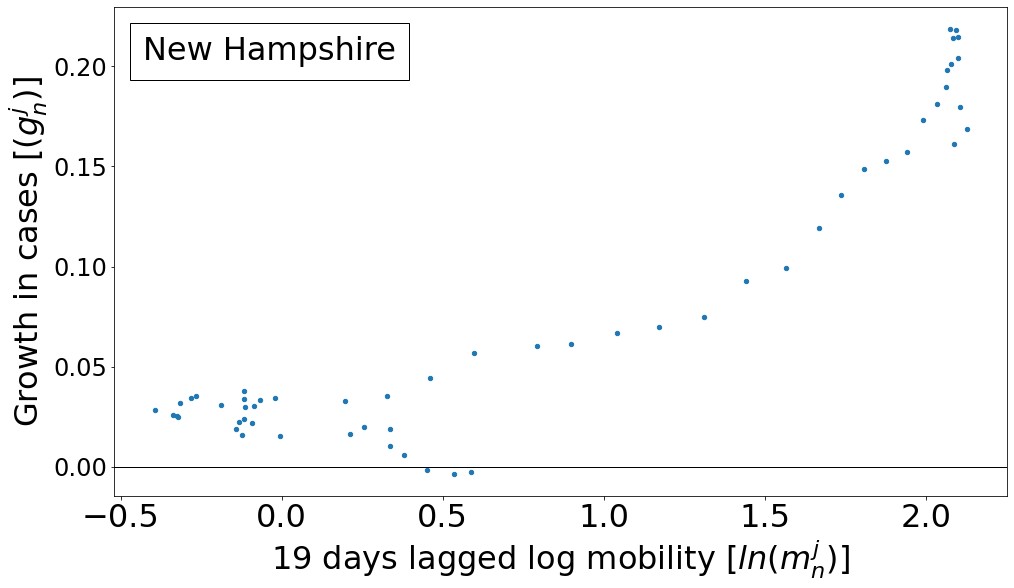

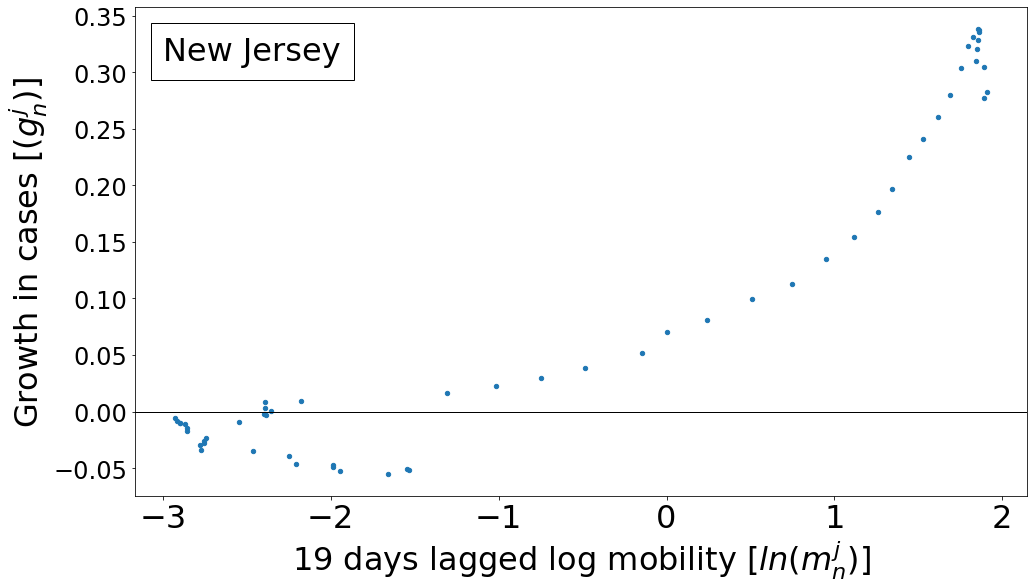

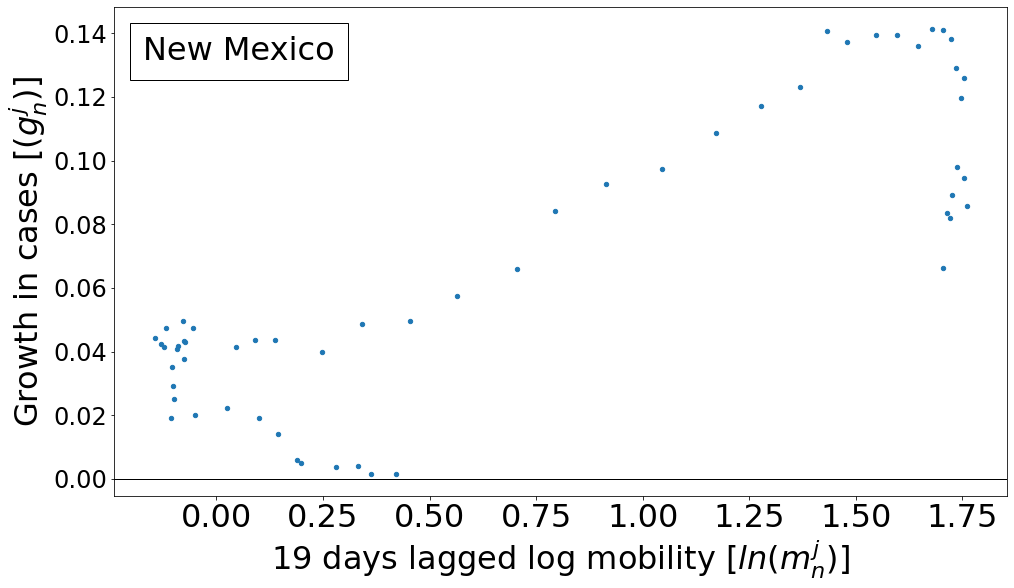

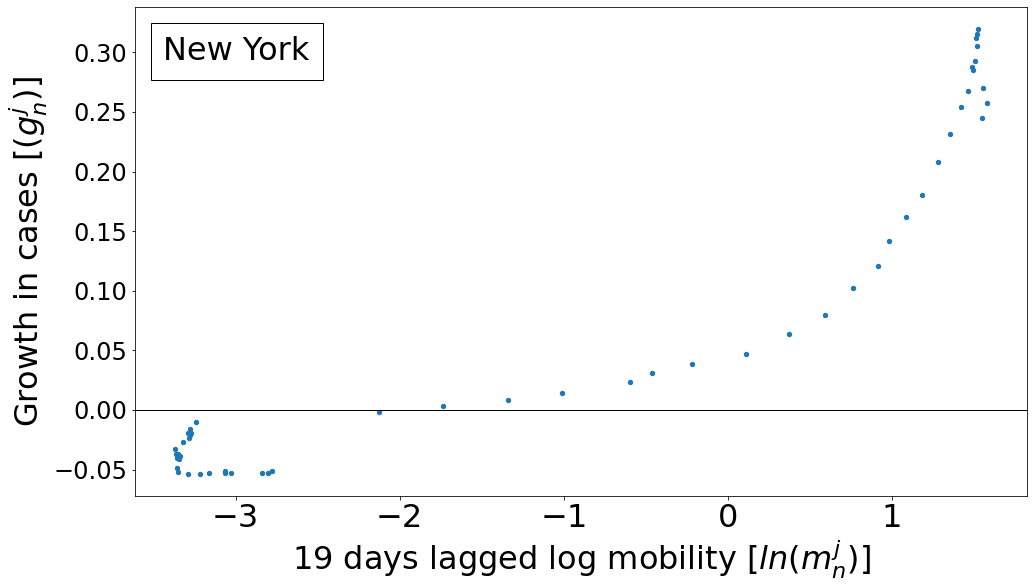

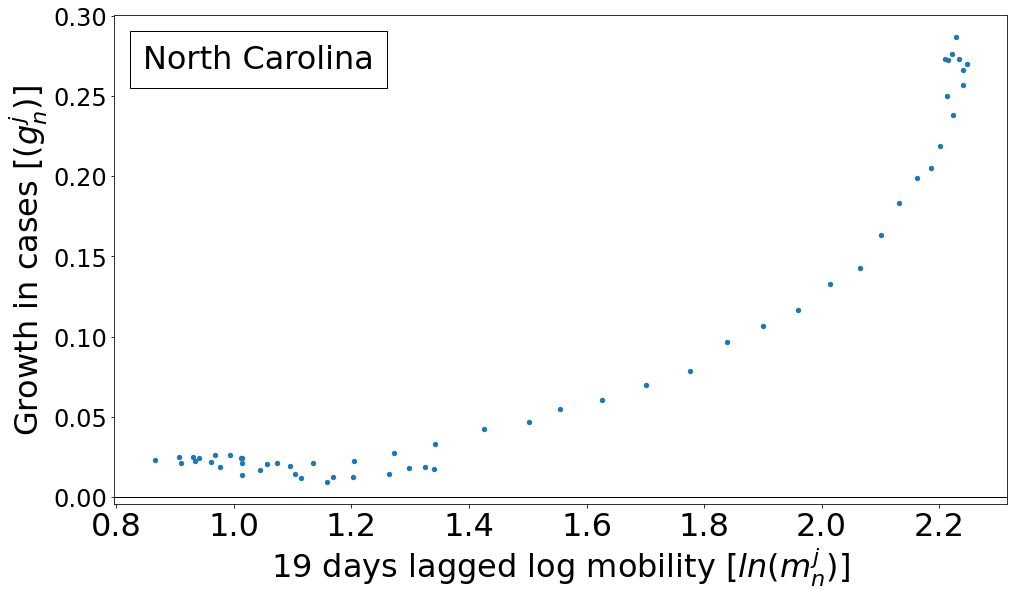

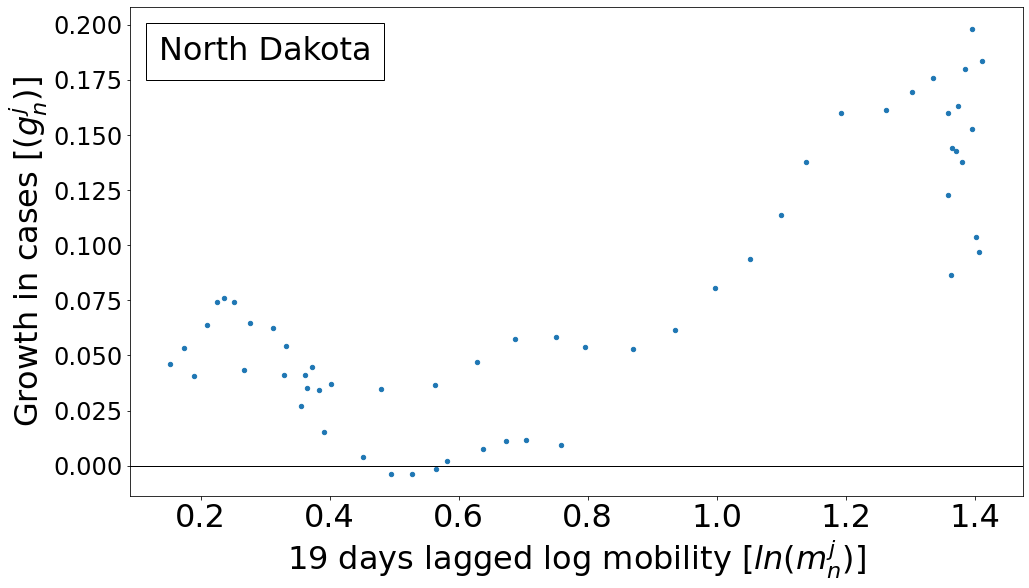

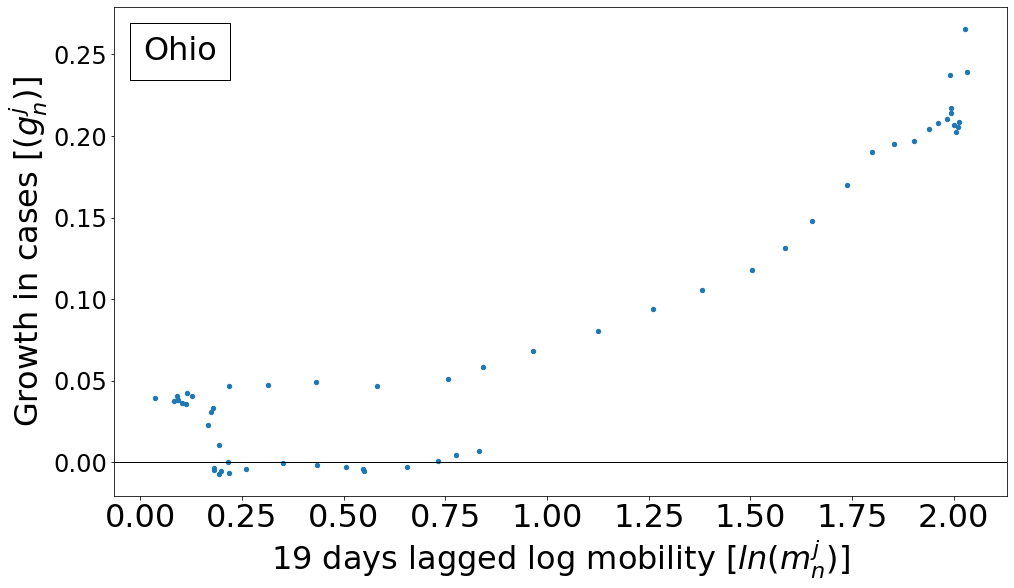

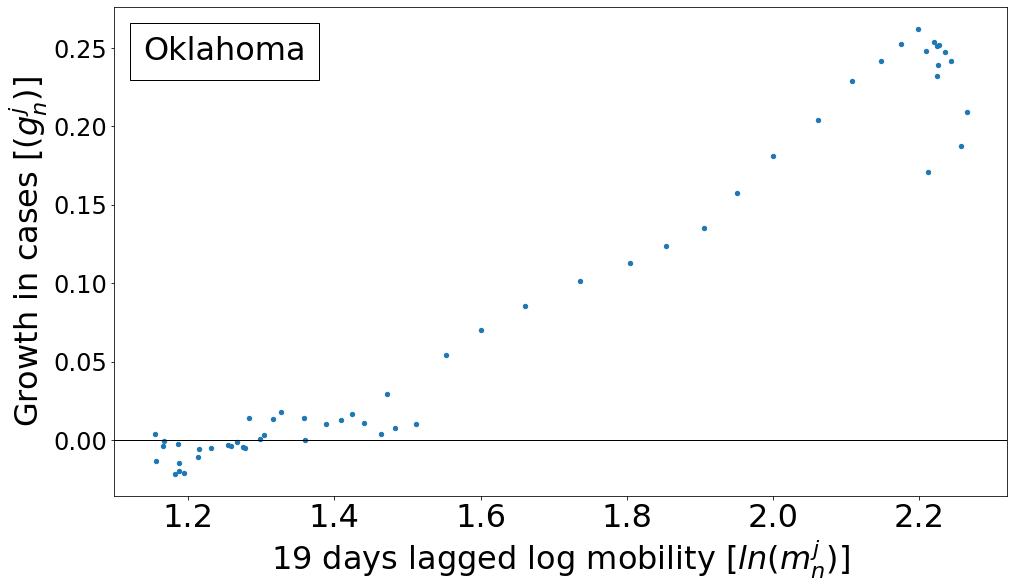

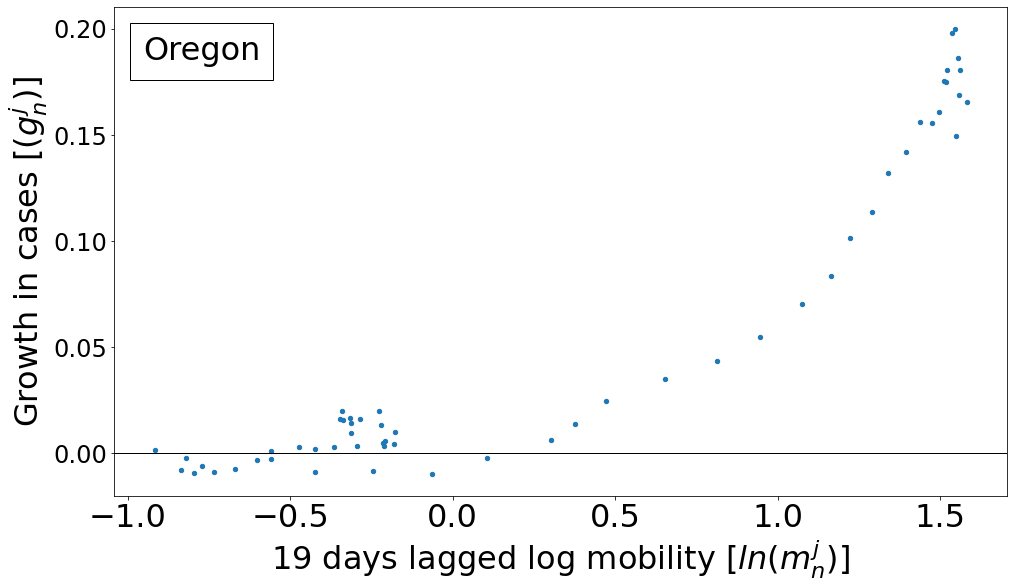

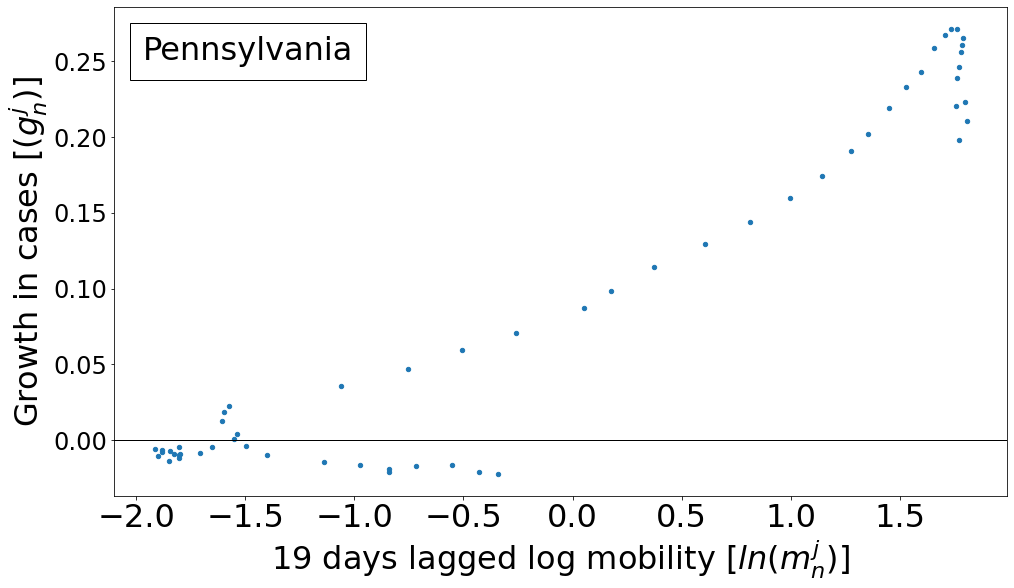

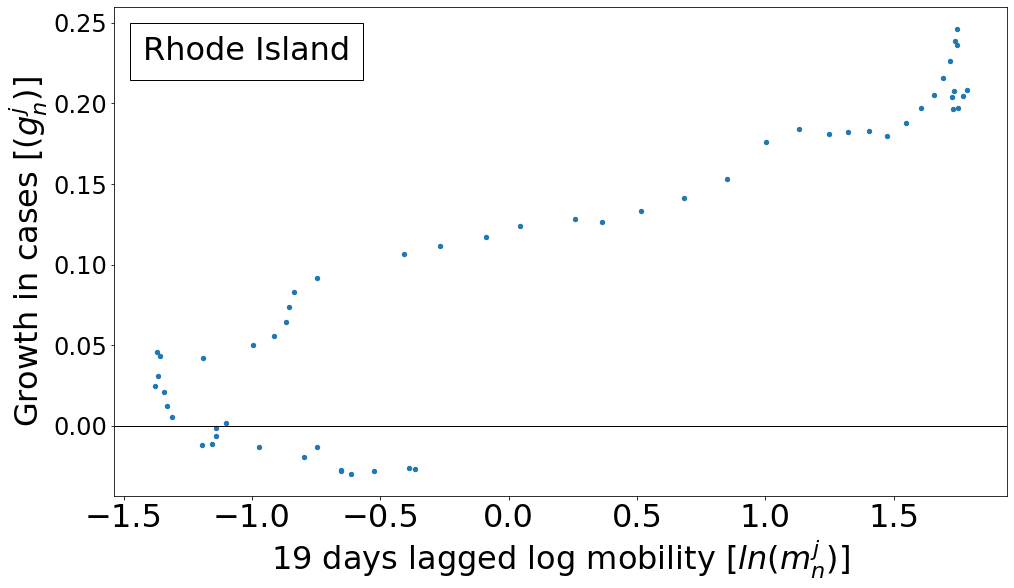

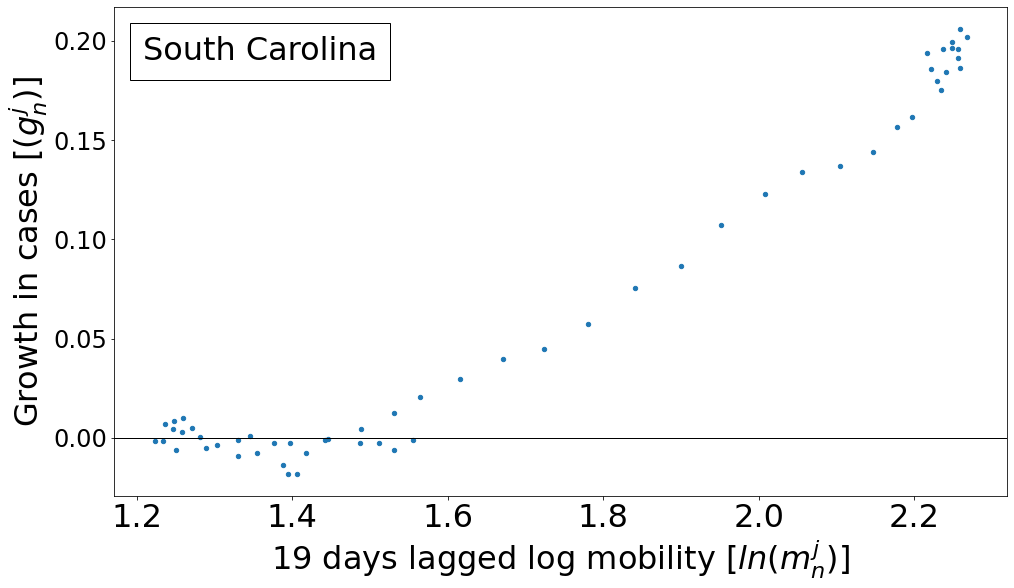

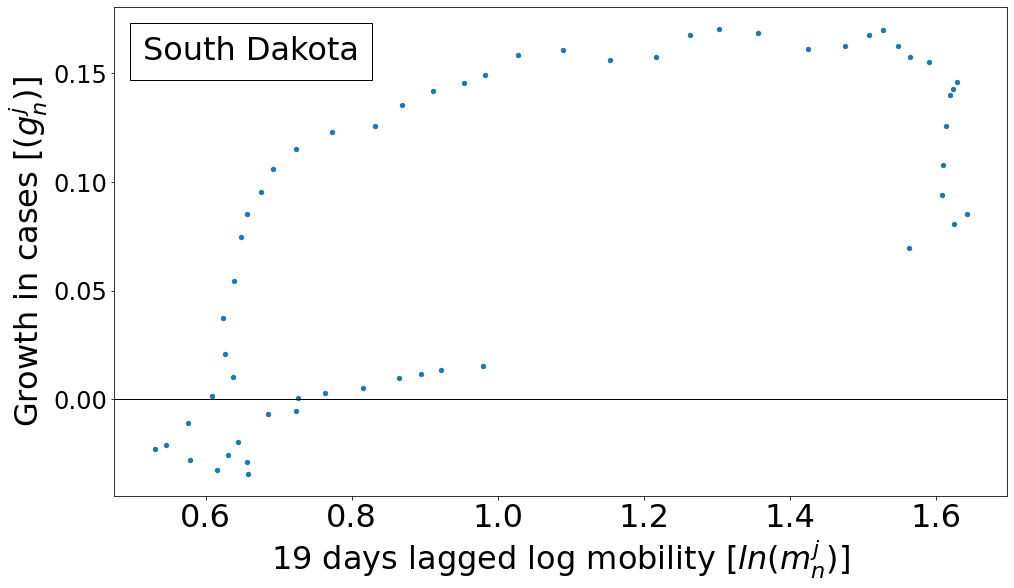

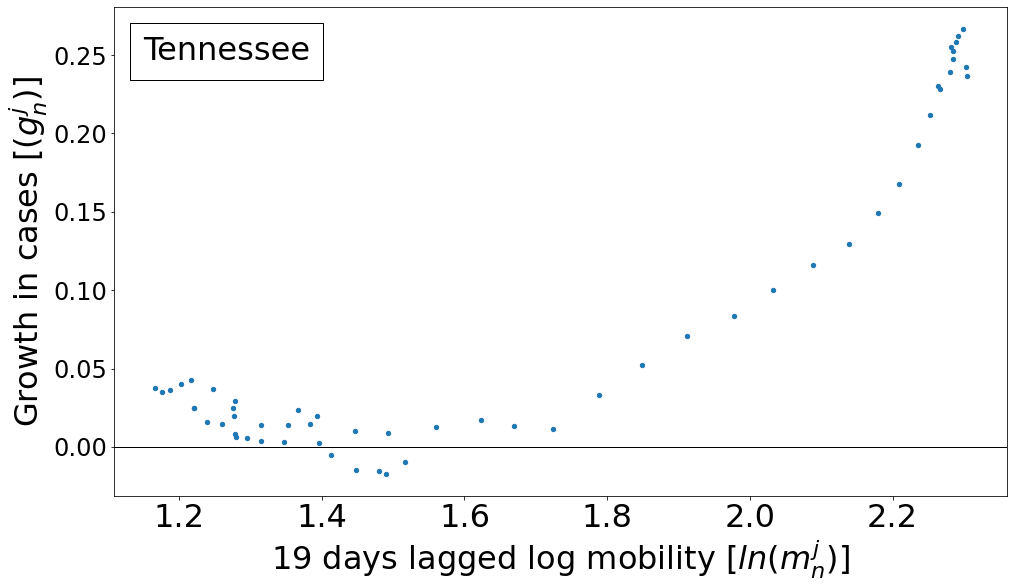

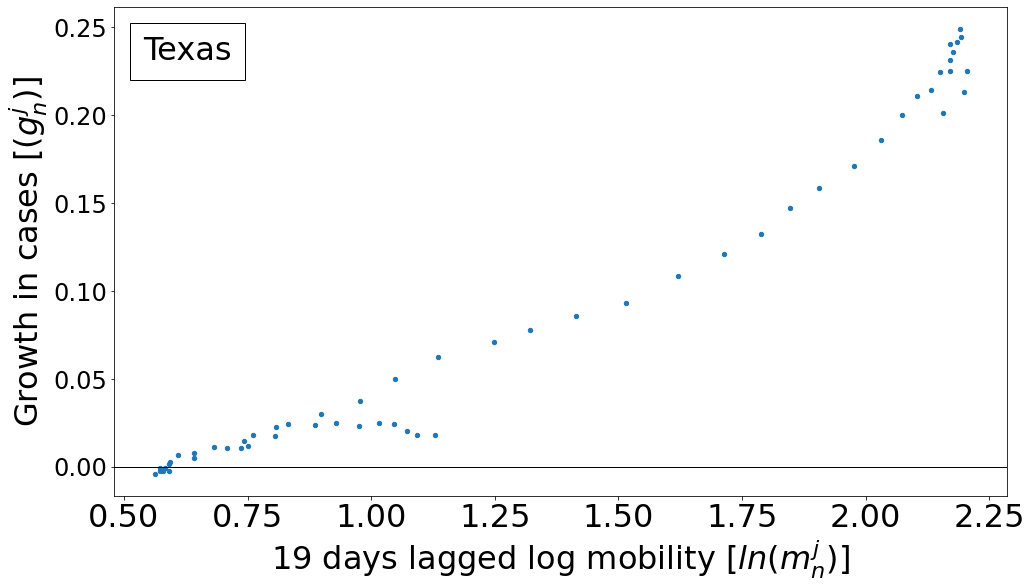

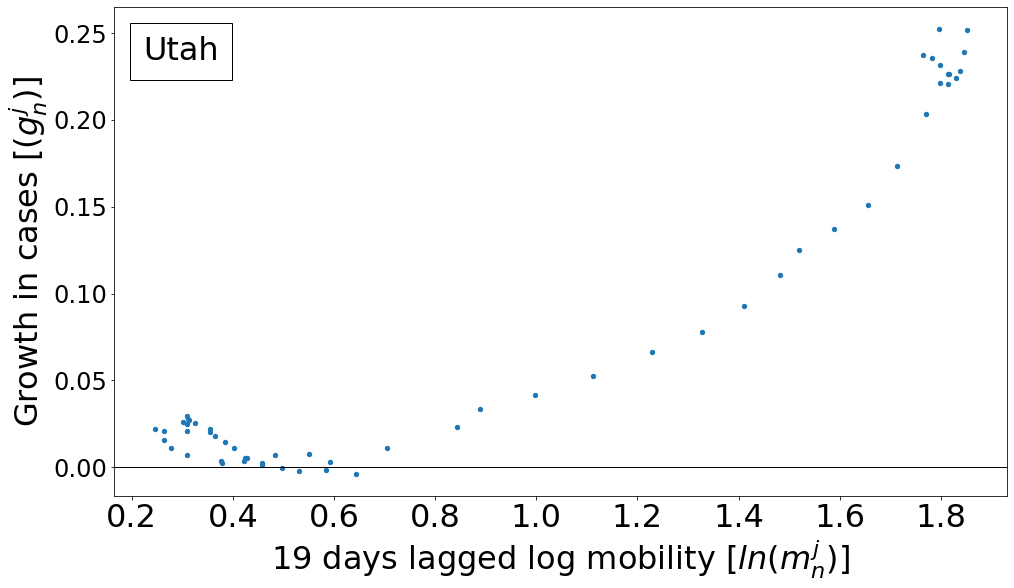

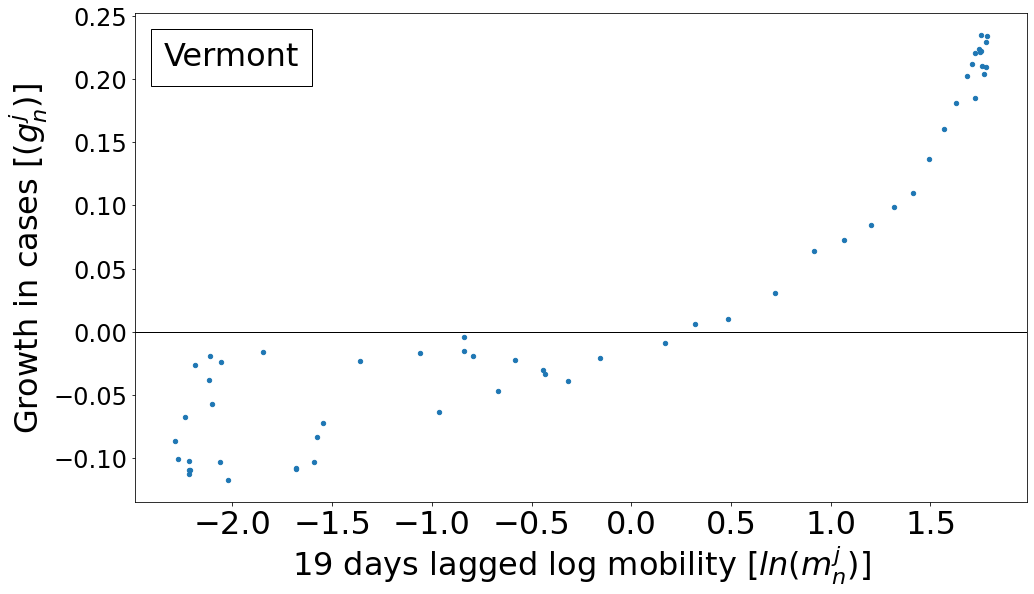

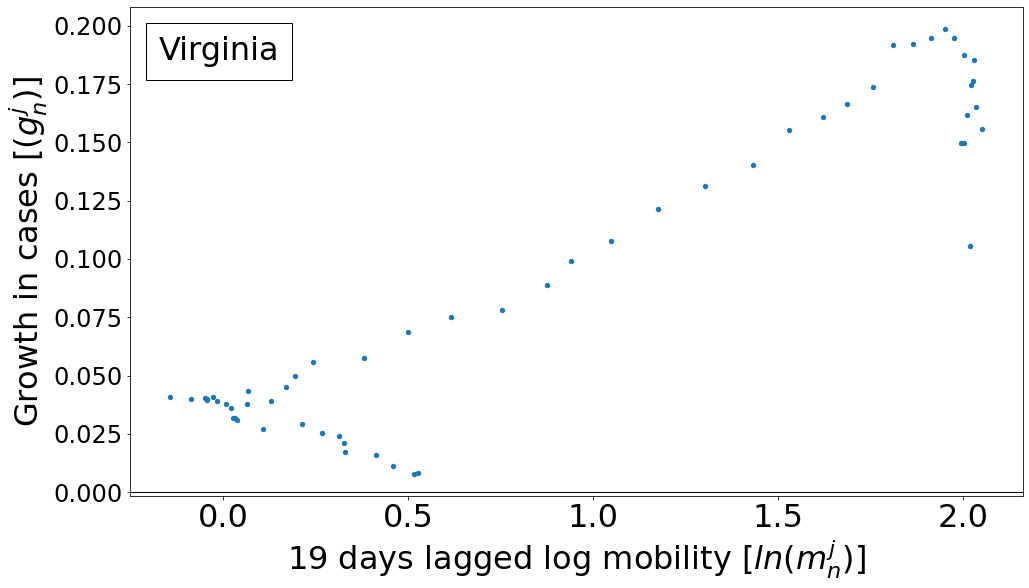

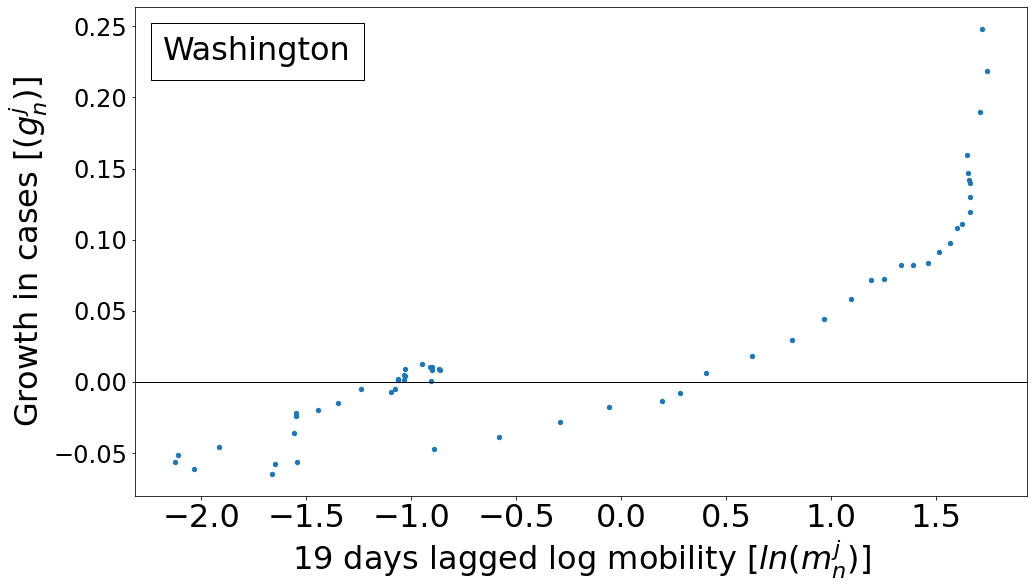

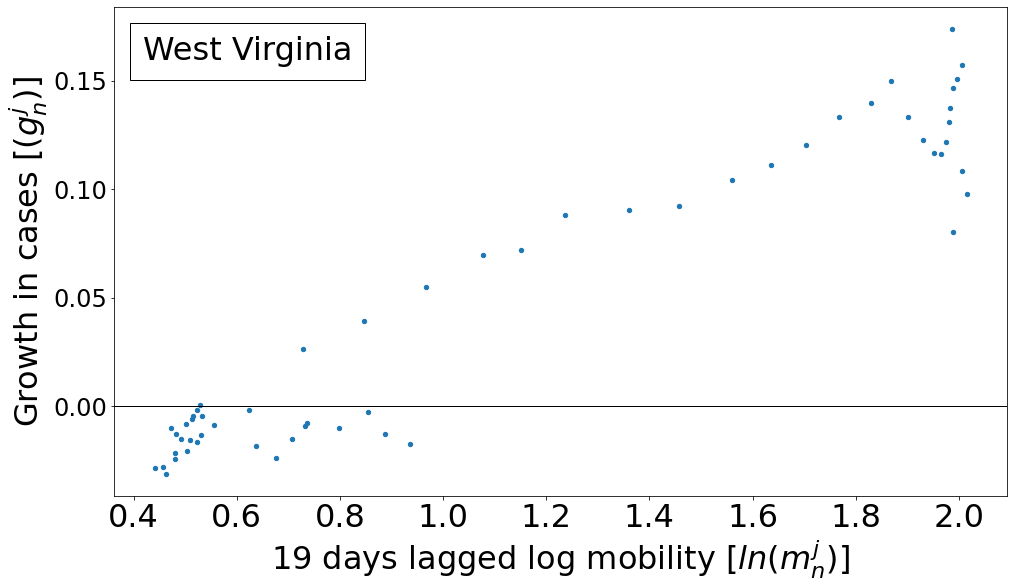

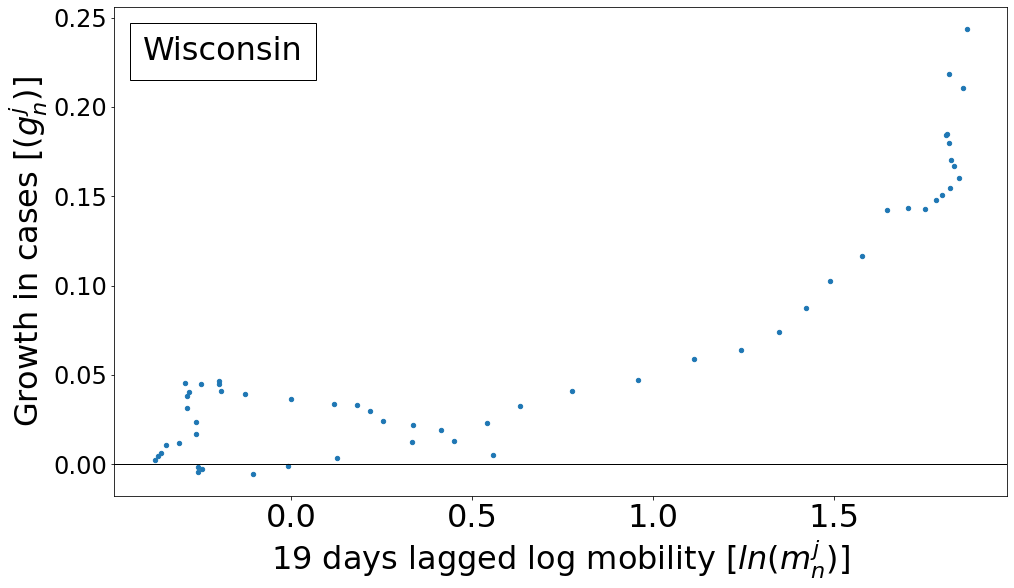

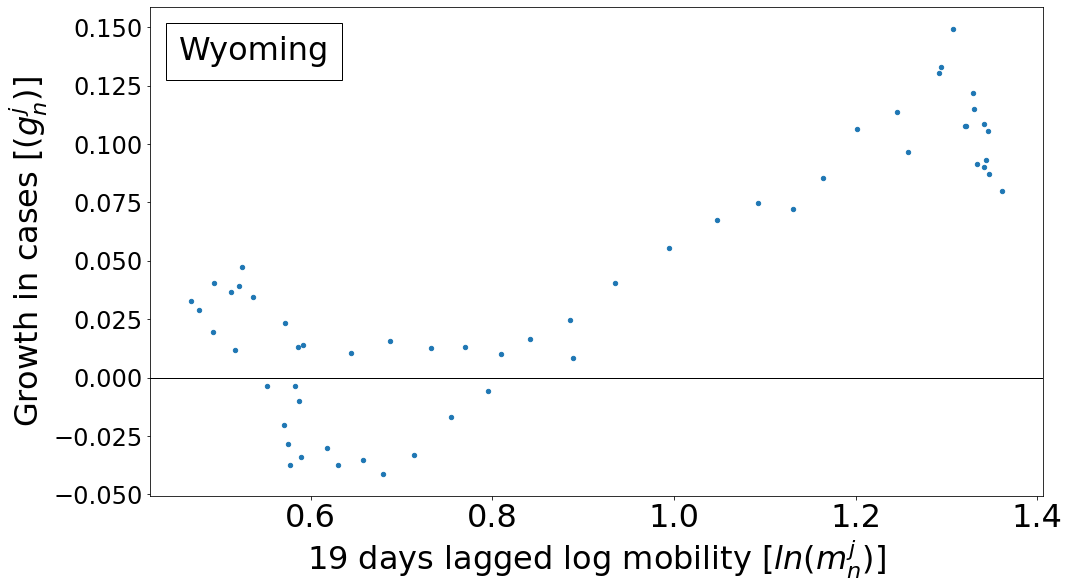

pairs_id         b0         b1  x-intercept         R2
count   51.000000  51.000000  51.000000    51.000000  51.000000
mean   146.000000  -0.037832   0.109451    -0.176382   0.822941
std     14.866069   0.126680   0.056940     1.222455   0.152109
min    121.000000  -0.328770   0.020624    -4.415078   0.230000
25%    133.500000  -0.095262   0.063381    -0.773681   0.795000
50%    146.000000   0.005630   0.100959    -0.086931   0.870000
75%    158.500000   0.046749   0.143515     0.676789   0.910000
max    171.000000   0.139144   0.245750     1.562535   0.970000

In [18]:
# Shutdown Period LogMobility

dt_cutoff_max = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_plot = df_lagged[df_lagged.index<=dt_cutoff_max]
df_summary = pandas.DataFrame()

for pairs_id in df_region.sort_values(by='State')['pairs_id'].values:
    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

    df_single = df_plot[pairs_id]
    
    if len(df_single)>0:
        plt.figure(figsize=(16,9))
        ax = plt.subplot(1,1,1)
        plt.scatter(df_single['LogMobility'], df_single['GrowthCases'], s=19)
        plt.axhline(color='k', lw=1)
        #plt.axvline(color='k', lw=1)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        plt.xlabel(str(cases_lag_measured) + ' days lagged log mobility $[ln(m^j_n)]$', size=32)
        plt.ylabel('Growth in cases $[(g^j_n)]$', size=32)
        plt.xticks(fontsize=32)
        plt.yticks(fontsize=24)

        try:
            # Linear Regression
            X = df_single['LogMobility']
            X = sm.add_constant(X) #intercept
            y = df_single['GrowthCases']
            model = sm.OLS(y, X)
            results = model.fit()
            #print('Parameters: ', results.params)
            #print('R2: ', results.rsquared)
            b0 = results.params.const
            b1 = results.params.LogMobility
            
            row['b0'] = b0
            row['b1'] = b1
            row['x-intercept'] = -b0/b1
            row['R2'] = numpy.round(results.rsquared, 2)

            x1 = df_single['LogMobility'].min() #-1
            x2 = df_single['LogMobility'].max() #2.5
            #plt.plot([x1, x2], [b1*x1+b0, b1*x2+b0], lw=4)

            #anchored_text = AnchoredText(str(numpy.round(b1, 3)) + 'x+' + str(numpy.round(b0, 3))+
            #                             '\nx-intercept '+str(numpy.round(-b0/b1, 2)), loc=2)
            #ax.add_artist(anchored_text)

            anchored_text = AnchoredText(title_string, loc=2, prop=dict(size=32))
            ax.add_artist(anchored_text)

        except: 
            pass

        plt.show()
        
    df_summary = df_summary.append(pandas.DataFrame(row, index=[0]))
df_summary.describe()


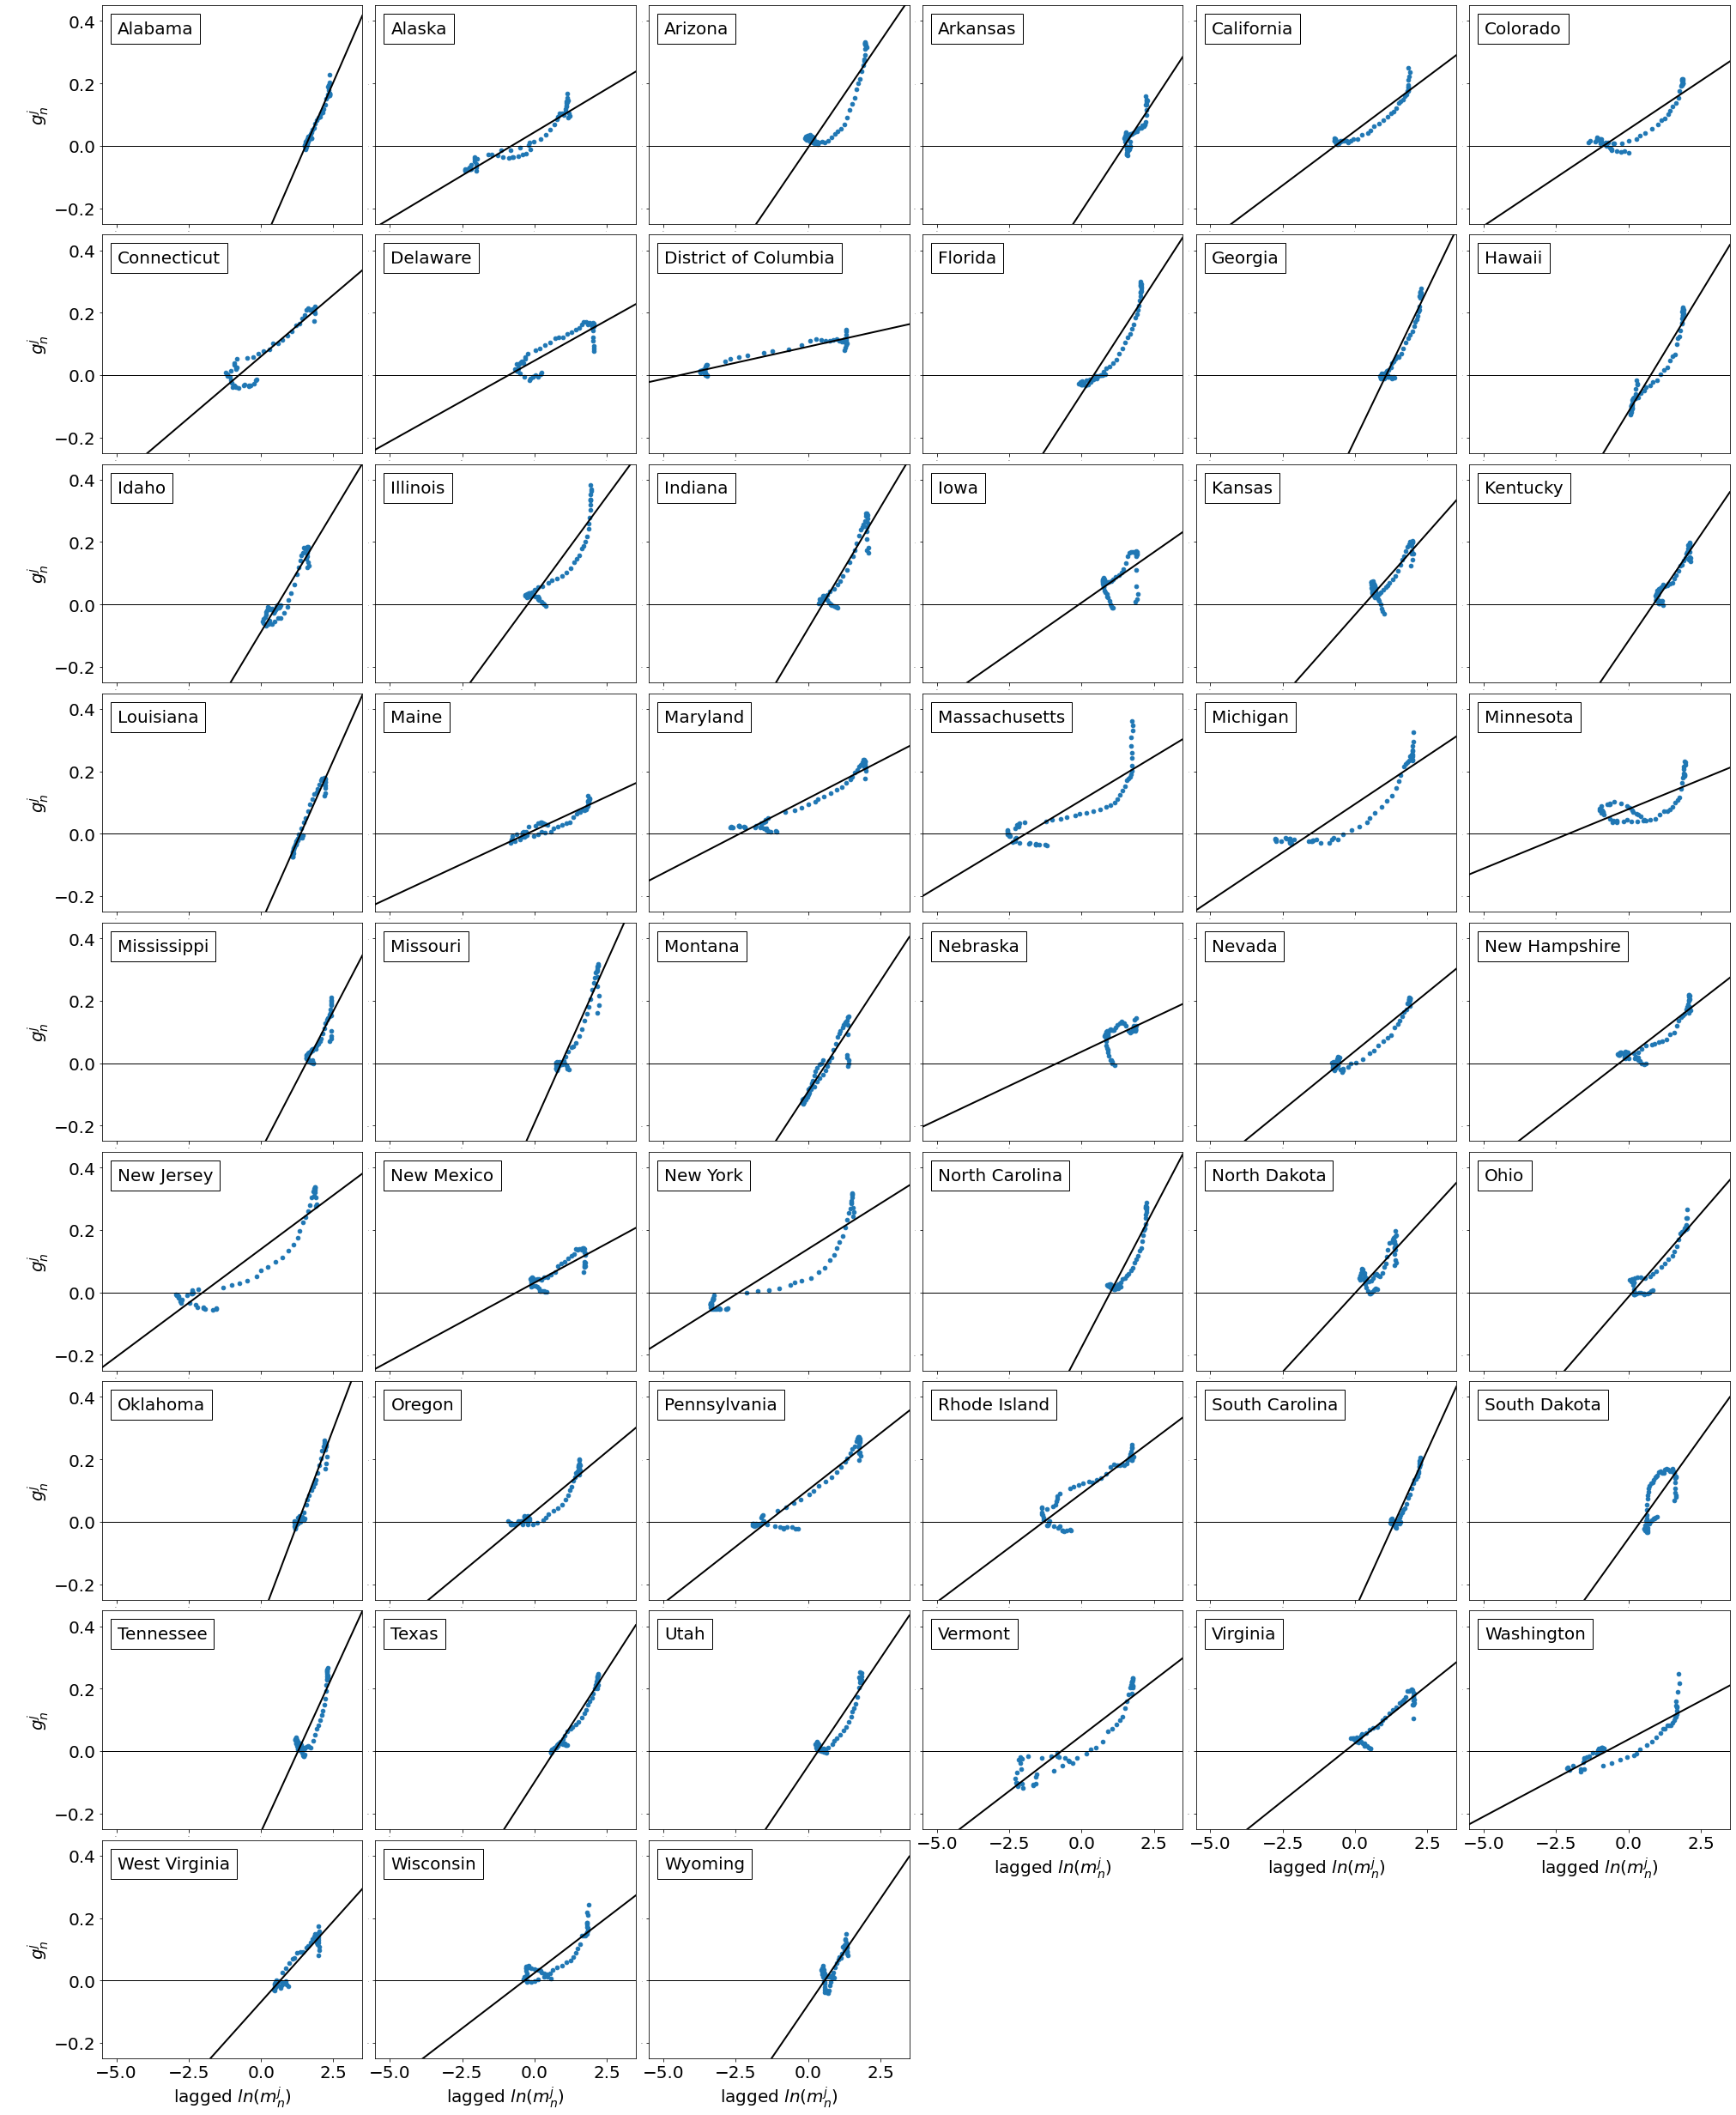

In [19]:
# Shutdown Period LogMobility
dt_cutoff_max = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_plot = df_lagged[df_lagged.index<=dt_cutoff_max]
df_summary = pandas.DataFrame()

fig = plt.figure(figsize=(34, 44)) # letter size 8.5 * 11
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, pairs_id in enumerate(df_region.sort_values(by='State')['pairs_id'].values):
    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

    df_single = df_plot[pairs_id]
    
    if len(df_single)>0:
        ax = plt.subplot(9, 6,i+1)
        plt.scatter(df_single['LogMobility'], df_single['GrowthCases'], s=21)
        plt.axhline(color='k', lw=1)
        #plt.axvline(color='k', lw=1)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        #plt.xlabel(str(cases_lag_measured) + ' days lagged log mobility $[ln(m^j_n)]$', size=12)
        #plt.ylabel('Growth in cases $[(g^j_n)]$', size=12)
        if (i>44):
            plt.xlabel('lagged $ln(m^j_n)$', size=20)
            plt.xticks(fontsize=20)
        else:
            plt.xticks(fontsize=0)
        if (i%6==0):
            plt.ylabel('\n$g^j_n$', size=20)
            plt.yticks(fontsize=20)
        else:
            plt.yticks(fontsize=0)
        #plt.xticks(fontsize=32)
        #plt.yticks(fontsize=24)

        try:
            # Linear Regression
            X = df_single['LogMobility']
            X = sm.add_constant(X) #intercept
            y = df_single['GrowthCases']
            model = sm.OLS(y, X)
            results = model.fit()
            #print('Parameters: ', results.params)
            #print('R2: ', results.rsquared)
            b0 = results.params.const
            b1 = results.params.LogMobility
            
            row['b0'] = b0
            row['b1'] = b1
            row['ln(m_c)'] = -b0/b1
            row['R2'] = numpy.round(results.rsquared, 2)

            x1 = -5.5 #-2.5 #df_single['LogMobility'].min() #-1
            x2 = 3.5 #1.5 #df_single['LogMobility'].max() #2.5
            plt.plot([x1, x2], [b1*x1+b0, b1*x2+b0], lw=2, c='k')
            
            ax.locator_params(tight=True, nbins=4)
            
            plt.xlim(xmin=x1, xmax=x2)
            plt.ylim(ymin=-0.25, ymax=0.45)
            
            #anchored_text = AnchoredText(title_string + '\n$ln(m_c)=$' + str(numpy.round(row['ln(m_c)'], 1)), 
            #                             loc=2, prop=dict(size=20))
            anchored_text = AnchoredText(title_string, loc=2, prop=dict(size=20))
            ax.add_artist(anchored_text)

            df_summary = df_summary.append(pandas.DataFrame(row, index=[0]))

        except: 
            pass
        

#plt.tight_layout()
plt.savefig(os.path.join(data_subdirectory, 'state_fits_RW14.svg'))
plt.show()

df_summary['R'] = numpy.sqrt(df_summary['R2']) * numpy.sign(df_summary['b1'])
df_summary = numpy.round(df_summary.rename(columns={'b0':'intercept', 'b1':'slope', 'R2':'R-squared'}), 3)

In [20]:
df_summary.describe()

pairs_id  intercept      slope    ln(m_c)  R-squared          R
count   51.000000  51.000000  51.000000  51.000000  51.000000  51.000000
mean   146.000000  -0.037804   0.109510  -0.176392   0.822941   0.902059
std     14.866069   0.126720   0.056922   1.222466   0.152109   0.097689
min    121.000000  -0.329000   0.021000  -4.415000   0.230000   0.480000
25%    133.500000  -0.095500   0.063500  -0.773500   0.795000   0.891500
50%    146.000000   0.006000   0.101000  -0.087000   0.870000   0.933000
75%    158.500000   0.046500   0.143500   0.677000   0.910000   0.954000
max    171.000000   0.139000   0.246000   1.563000   0.970000   0.985000

In [21]:
# Log scale correlation
numpy.round(df_summary[['slope', 'R']].describe().T, 3)

count   mean    std    min    25%    50%    75%    max
slope   51.0  0.110  0.057  0.021  0.064  0.101  0.144  0.246
R       51.0  0.902  0.098  0.480  0.892  0.933  0.954  0.985

In [22]:
cols = ['State', 'R', 'slope', 'ln(m_c)']
df_summary[cols].to_csv(os.path.join(data_subdirectory, 'state_fits_RW14_summary.csv'), index=False)
df_summary[cols].set_index('State')

R  slope  ln(m_c)
State                                      
Alabama               0.985  0.213    1.543
Alaska                0.949  0.056   -0.787
Arizona               0.922  0.136    0.045
Arkansas              0.831  0.141    1.480
California            0.954  0.070   -0.679
Colorado              0.906  0.062   -0.865
Connecticut           0.949  0.079   -0.759
Delaware              0.866  0.052   -0.893
District of Columbia  0.964  0.021   -4.415
Florida               0.949  0.143    0.419
Georgia               0.964  0.193    1.074
Hawaii                0.970  0.153    0.764
Idaho                 0.954  0.154    0.571
Illinois              0.917  0.126   -0.242
Indiana               0.938  0.156    0.501
Iowa                  0.583  0.065   -0.087
Kansas                0.866  0.105    0.313
Kentucky              0.959  0.136    0.854
Louisiana             0.985  0.208    1.368
Maine                 0.949  0.043   -0.263
Maryland              0.964  0.048   -2.364
Massachusetts         0.866  0.056   -1.924
Michigan              0.922  0.062   -1.539
Minnesota             0.700  0.038   -2.079
Mississippi           0.900  0.178    1.563
Missouri              0.959  0.207    0.925
Montana               0.917  0.142    0.646
Nebraska              0.480  0.044   -0.834
Nevada                0.959  0.076   -0.509
New Hampshire         0.922  0.072   -0.316
New Jersey            0.933  0.069   -2.012
New Mexico            0.849  0.050   -0.624
New York              0.927  0.058   -2.384
North Carolina        0.927  0.177    0.994
North Dakota          0.787  0.101    0.020
Ohio                  0.933  0.107    0.130
Oklahoma              0.980  0.246    1.285
Oregon                0.933  0.077   -0.414
Pennsylvania          0.954  0.073   -1.400
Rhode Island          0.917  0.070   -1.303
South Carolina        0.970  0.204    1.374
South Dakota          0.700  0.129    0.410
Tennessee             0.894  0.202    1.279
Texas                 0.980  0.144    0.689
Utah                  0.938  0.138    0.348
Vermont               0.927  0.071   -0.697
Virginia              0.938  0.074   -0.344
Washington            0.883  0.049   -0.760
West Virginia         0.954  0.104    0.665
Wisconsin             0.889  0.071   -0.339
Wyoming               0.843  0.136    0.576

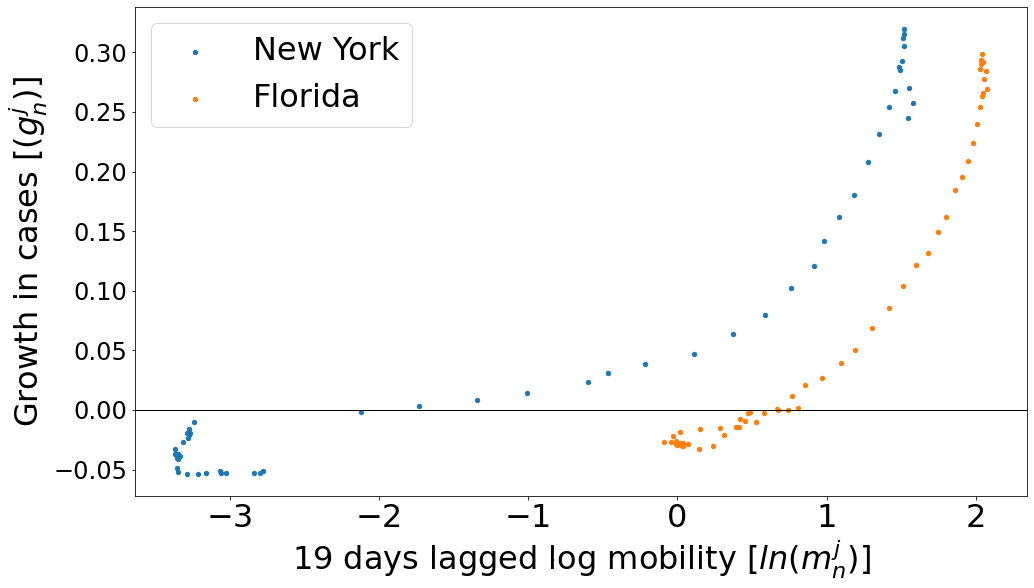

In [23]:
# Shutdown Period LogMobility

dt_cutoff_max = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_plot = df_lagged[df_lagged.index<=dt_cutoff_max]
df_states_chosen = df_region[df_region['State'].isin(['Florida', 'New York'])]
df_states_chosen = df_states_chosen.sort_values(by='State', ascending=False)

plt.figure(figsize=(16,9))
for pairs_id in df_states_chosen['pairs_id'].values:
    df_single = df_plot[pairs_id]    
    if len(df_single)>0:
        plt.scatter(df_single['LogMobility'], df_single['GrowthCases'], 
                    s=19, 
                    label=df_region[df_region['pairs_id']==pairs_id]['State'].values[0])
        plt.axhline(color='k', lw=1)
        #plt.axvline(color='k', lw=1)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        plt.xlabel(str(cases_lag_measured) + ' days lagged log mobility $[ln(m^j_n)]$', size=32)
        plt.ylabel('Growth in cases $[(g^j_n)]$', size=32)
        plt.xticks(fontsize=32)
        plt.yticks(fontsize=24)

plt.legend(fontsize=32)
plt.savefig(os.path.join(data_subdirectory, 'fig_1_E.svg'))
plt.show()